# Income Classification


**Objective:** Predict whether an individual’s income exceeds $50,000 per year based on various demographic attributes

dataset: https://archive.ics.uci.edu/dataset/2/adult

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report,  confusion_matrix, roc_curve, auc,  make_scorer, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.inspection import permutation_importance
import scipy.stats as stats
import joblib
import os

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
pd.set_option('display.max_rows', None)

# Get the data

## Import csv file

In [4]:
full_data = pd.read_csv('dataset/adult-all.csv')

In [5]:
full_data.columns = full_data.columns.str.strip()

In [6]:
full_data.columns

Index(['39', 'State-gov', '77516', 'Bachelors', '13', 'Never-married',
       'Adm-clerical', 'Not-in-family', 'White', 'Male', '2174', '0', '40',
       'United-States', '<=50K'],
      dtype='object')

## Rename features

In [7]:
# Transform columns to correct names
column_mapping = {'39': 'age',
                  'State-gov': 'work-class',
                  '77516': 'final-weight',
                  'Bachelors' : 'education',
                  '13' : 'education-num', 
                  'Never-married' : 'marital-status',
                  'Adm-clerical' : 'occupation',
                  'Not-in-family' : 'relationship',
                  'White' : 'race', 
                  'Male' :'gender',
                  '2174' : 'capital-gain',
                  '0' : 'capital-loss',
                  '40' : 'hours-per-week',
                  'United-States' : 'native-country',
                  '<=50K' : 'income_>50K'
}

full_data.rename(columns=column_mapping, inplace=True)

## Data cleanup

In [8]:
full_data.replace({
    # 'income_>50K': {'<=50K': 0, '>50K': 1},
    'work-class': {'Private': 'Private sector', 'Self-emp-not-inc': 'Self employed (not incorporated)', 'Local-gov':'Local government', 
                  'State-gov':'State governemnt', 'Self-emp-inc':'Self employed (incorporated)', 'Without-pay':'Without work',
                  'Federal-gov':'Federal government'},
    'marital-status': {'Married-civ-spouse': 'Married (civilian spouse)', 'Never-married': 'Never married', 'Divorced':'Divorced', 'Separated':'Separated',
                      'Widowed':'Widowed', 'Married-spouse-absent':'Married (abscent spouse)', 'Married-AF-spouse':'Married (armed forces spouse)'},
    'education': {'Preschool': 'Pre-school', '1st-4th': '1st to 4th grade', '5th-6th':'5th to 6th grade', '7th-8th':'7th to 8th grade',
                 '9th':'9th grade', '10th':'10th grade', '11th':'11th grade', '12th':'12th grade no diploma', 'Some-college':'Some college',
                 'Assoc-voc':'Associate degree (vocation)', 'Assoc-acdm':'Associate degree (academic)', 'Bachelors':'Bachelor\'s degree',
                 'Masters':'Master\'s degree', 'Prof-school':'Professional school', 'Doctorate':'Doctorate degree', 'Doctorate':'Doctorate degree', 'HS-grad':'High school graduate'},
    'occupation': {'Craft-repair': 'Craftman & repair', 'Prof-specialty': 'Professional specialty', 'Exec-managerial':'Executive and managerial role', 'Adm-clerical':'Administrative clerk',
                 'Sales':'Sales', 'Other-service':'Other services', 'Machine-op-inspct':'Machine operator & inspector', 'Transport-moving':'Transportation & moving', 'Handlers-cleaners':'Handlers & cleaners',
                 'Farming-fishing':'Farming & fishing', 'Tech-suppor':'Technical support', 'Protective-serv':'Protective service',
                 'Priv-house-serv':'Private house service', 'Armed-Forces':'Armed forces'},
    'relationship': {'Husband': 'Husband', 'Not-in-family': 'Not in a family', 'Own-child':'Own child', 'Unmarried':'Not married', ' Wife':'Wife', 'Other-relative':'Other relative'},
    'race': {'White': 'White', 'Black': 'Black', 'Asian-Pac-Islander':'Asian & pacific islander', 'Amer-Indian-Eskimo':'American first nation', 'Other':'Other'}
}, inplace=True)

In [9]:
full_data = full_data.drop(full_data[full_data['occupation'] == '?'].index)
full_data = full_data.drop(full_data[full_data['work-class'] == '?'].index)
full_data = full_data.drop(full_data[full_data['native-country'] == '?'].index)

## Split the data into training and test sets

In [10]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [11]:
train_original, test_original = data_split(full_data, 0.2)

In [12]:
train_original.shape, test_original.shape

((36176, 15), (9045, 15))

In [13]:
train_copy = train_original.copy()
test_copy = test_original.copy()

# Explore the data

## Quick glace at the data

In [13]:
full_data.head()

,age,work-class,final-weight,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,50,Self employed (not incorporated),83311,Bachelor's degree,13,Married (civilian spouse),Executive and managerial role,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private sector,215646,High school graduate,9,Divorced,Handlers & cleaners,Not in a family,White,Male,0,0,40,United-States,<=50K
2,53,Private sector,234721,11th grade,7,Married (civilian spouse),Handlers & cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private sector,338409,Bachelor's degree,13,Married (civilian spouse),Professional specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private sector,284582,Master's degree,14,Married (civilian spouse),Executive and managerial role,Wife,White,Female,0,0,40,United-States,<=50K


In [14]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45221 entries, 0 to 48840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45221 non-null  int64 
 1   work-class      45221 non-null  object
 2   final-weight    45221 non-null  int64 
 3   education       45221 non-null  object
 4   education-num   45221 non-null  int64 
 5   marital-status  45221 non-null  object
 6   occupation      45221 non-null  object
 7   relationship    45221 non-null  object
 8   race            45221 non-null  object
 9   gender          45221 non-null  object
 10  capital-gain    45221 non-null  int64 
 11  capital-loss    45221 non-null  int64 
 12  hours-per-week  45221 non-null  int64 
 13  native-country  45221 non-null  object
 14  income_>50K     45221 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [15]:
full_data.describe()

,age,final-weight,education-num,capital-gain,capital-loss,hours-per-week
count,45221.000000,4.522100e+04,45221.000000,45221.000000,45221.000000,45221.000000
mean,38.547931,1.897372e+05,10.118396,1101.406625,88.597377,40.938038
std,13.218016,1.056390e+05,2.552873,7506.511388,404.960355,12.007640
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173920e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783190e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379280e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


## Bivariate Analysis with target variable

In [16]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [17]:
# Function to create horizontal stacked bar plots with value labels and adjusted legend position
def plot_stacked_bar_horizontal(data, feature, target='income_>50K', palette='viridis'):
    # Calculate the counts for each category in the feature
    counts = data.groupby([feature, target]).size().unstack().fillna(0)
    
    # Normalize the counts to get proportions
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot
    ax = proportions.plot(kind='barh', stacked=True, figsize=(10, 8), colormap=palette, width=0.8)
    plt.title(f'income_>50K by {feature}')
    plt.xlabel('Frequency(%)')
    plt.ylabel(feature)
    plt.legend(title='target', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create the 'images' directory if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')
    
    # Save the plot as an image file
    plt.savefig(f'images/{feature}_frequency(%).png', bbox_inches='tight')
    plt.show()

In [36]:
def plot_histogram(data, feature, target='income_>50K', palette='viridis', bins=100):
    plt.figure(figsize=(18, 10))
    sns.histplot(data=data, x=feature, hue=target, multiple='stack', palette=palette)
    plt.title(f'Histogram of {feature} by {target}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

### Workclass

In [19]:
value_cnt_norm_cal(full_data,'work-class')

,Count,Frequency (%)
work-class,,
Private sector,33307,73.653833
Self employed (not incorporated),3796,8.394330
Local government,3100,6.855222
State governemnt,1945,4.301099
Self employed (incorporated),1646,3.639902
Federal government,1406,3.109175
Without work,21,0.046439


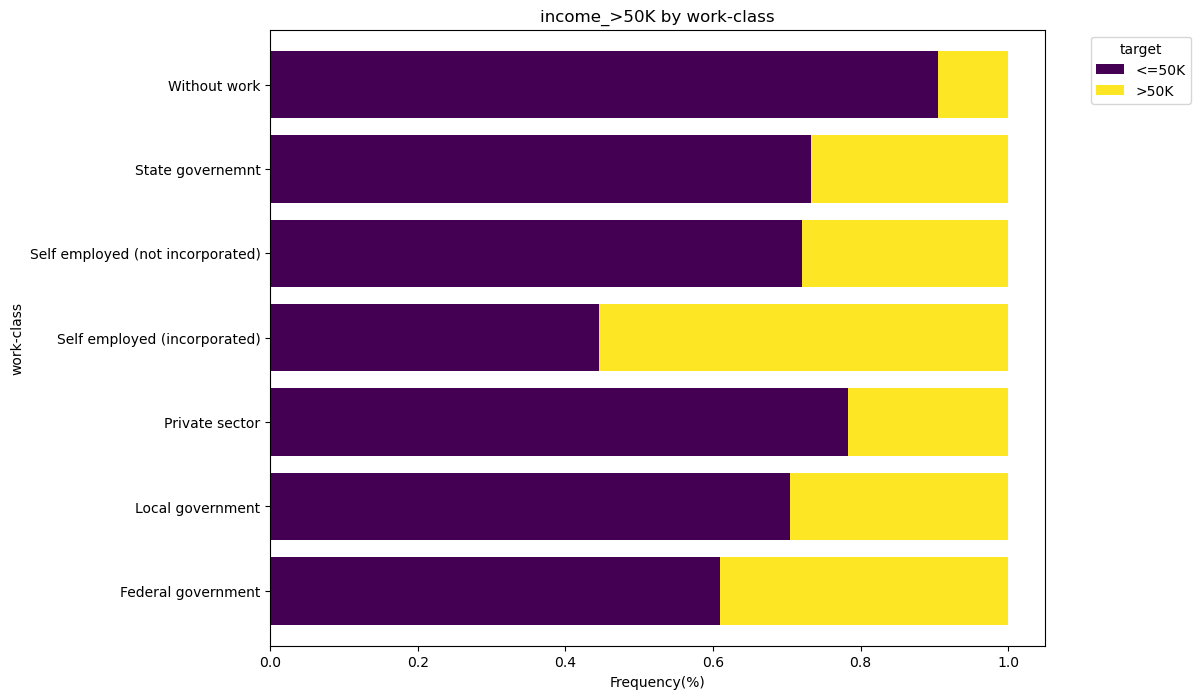

In [20]:
plot_stacked_bar_horizontal(full_data, 'work-class', palette='viridis')

**Insights**

- Self Employed (Incorporated) individuals have the highest percentage (55.4%) of earning more than 50K.
- Without Work individuals have the lowest percentage (9.5%) of earning more than 50K.
- Federal Government employees have a relatively higher percentage (39.0%) of earning more than 50K compared to other government sectors

### Education

In [21]:
value_cnt_norm_cal(full_data,'education')

,Count,Frequency (%)
education,,
High school graduate,14783,32.690564
Some college,9899,21.890272
Bachelor's degree,7569,16.737799
Master's degree,2514,5.559364
Associate degree (vocation),1959,4.332058
11th grade,1619,3.580195
Associate degree (academic),1507,3.332523
10th grade,1223,2.704496
7th to 8th grade,823,1.819951


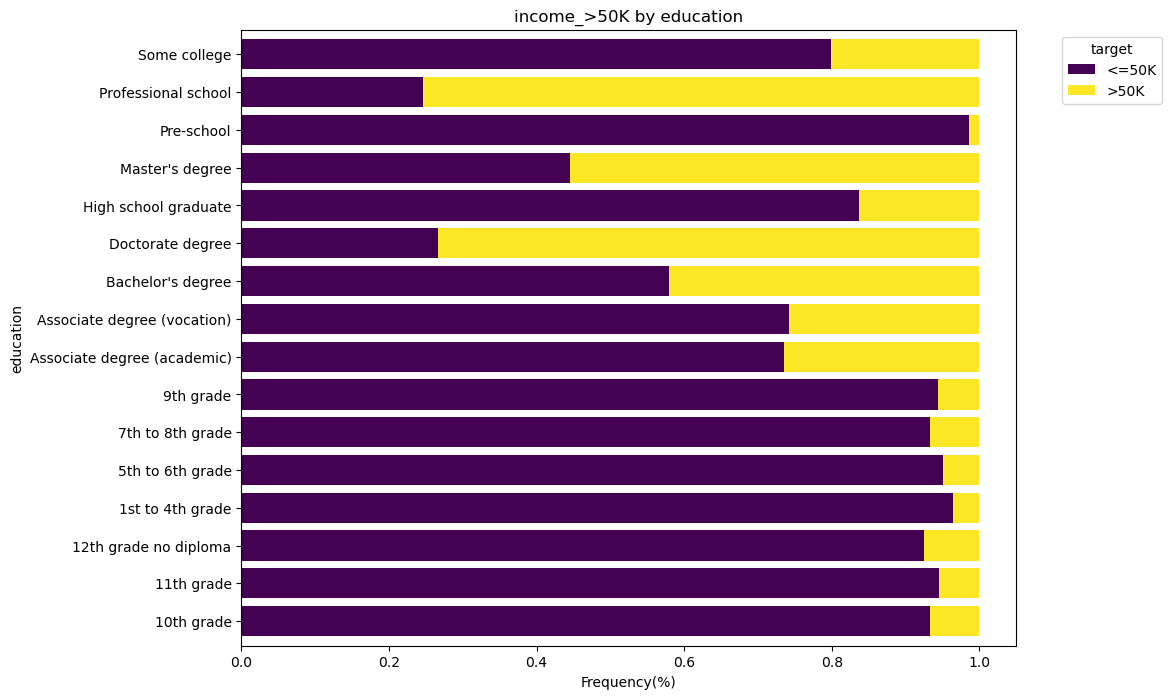

In [22]:
plot_stacked_bar_horizontal(full_data, 'education', palette='viridis')

**Insights**

- Doctorate Degree holders have the highest percentage (73.3%) of earning more than 50K, followed closely by those with a - -- Professional School education (75.4%).
- Pre-School education has the lowest percentage (1.4%) of individuals earning more than 50K, which is expected given the early stage of education.
- Bachelor’s Degree holders have a significant percentage (42.0%) of earning more than 50K, indicating the value of higher education

**Interpretation**


These percentages highlight the strong correlation between higher education levels and higher income. Advanced degrees such as Doctorates and Professional School qualifications significantly increase the likelihood of earning more tha 50K
Conversely, lower education levels, such as high school or below, are associated with a higher percentage of individuals earning less than 50K..

### Marital status

In [23]:
value_cnt_norm_cal(full_data,'marital-status')

,Count,Frequency (%)
marital-status,,
Married (civilian spouse),21055,46.560226
Never married,14597,32.279251
Divorced,6297,13.924946
Separated,1411,3.120232
Widowed,1277,2.823909
Married (abscent spouse),552,1.220672
Married (armed forces spouse),32,0.070764


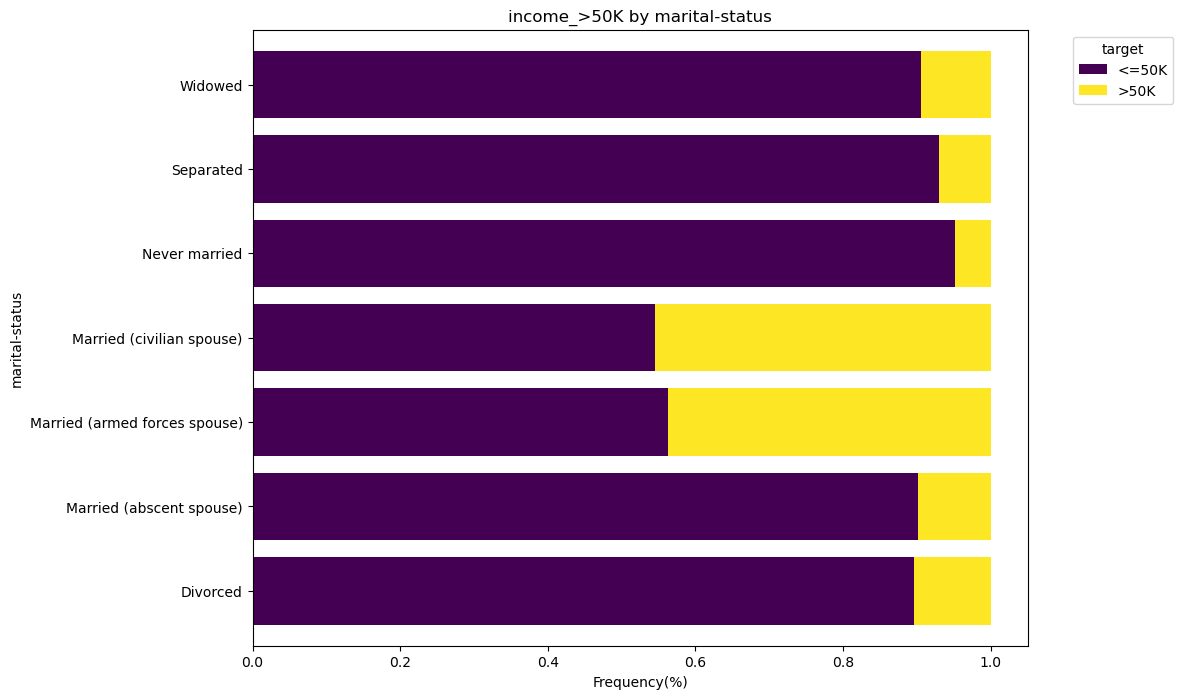

In [24]:
plot_stacked_bar_horizontal(full_data, 'marital-status', palette='viridis')

**Insights**
  
- Married (Civilian Spouse) individuals have the highest percentage (45.4%) of earning more than 50K, closely followed by those Married (Armed Forces Spouse) (43.8%).
- Never Married individuals have the lowest percentage (4.8%) of earning more than 50K.
- Divorced, Separated, and Widowed individuals have relatively low percentages of earning more than 50K, with Divorced individuals at 10.4%, Separated at 7.0%, and Widowed at 9.5%.

**Interpretation**

These percentages highlight the correlation between marital status and income levels. Being married, especially with a civilian or armed forces spouse, is associated with a higher likelihood of earning morethan 50K. On the other hand, individuals who are never married, separated, or widowed tend to have a lower likelihood of earning more than 50K..

### Occupation

In [25]:
value_cnt_norm_cal(full_data,'occupation')

,Count,Frequency (%)
occupation,,
Craftman & repair,6020,13.312399
Professional specialty,6008,13.285863
Executive and managerial role,5984,13.232790
Administrative clerk,5539,12.248734
Sales,5408,11.959046
Other services,4808,10.632228
Machine operator & inspector,2970,6.567745
Transportation & moving,2316,5.121514
Handlers & cleaners,2046,4.524447


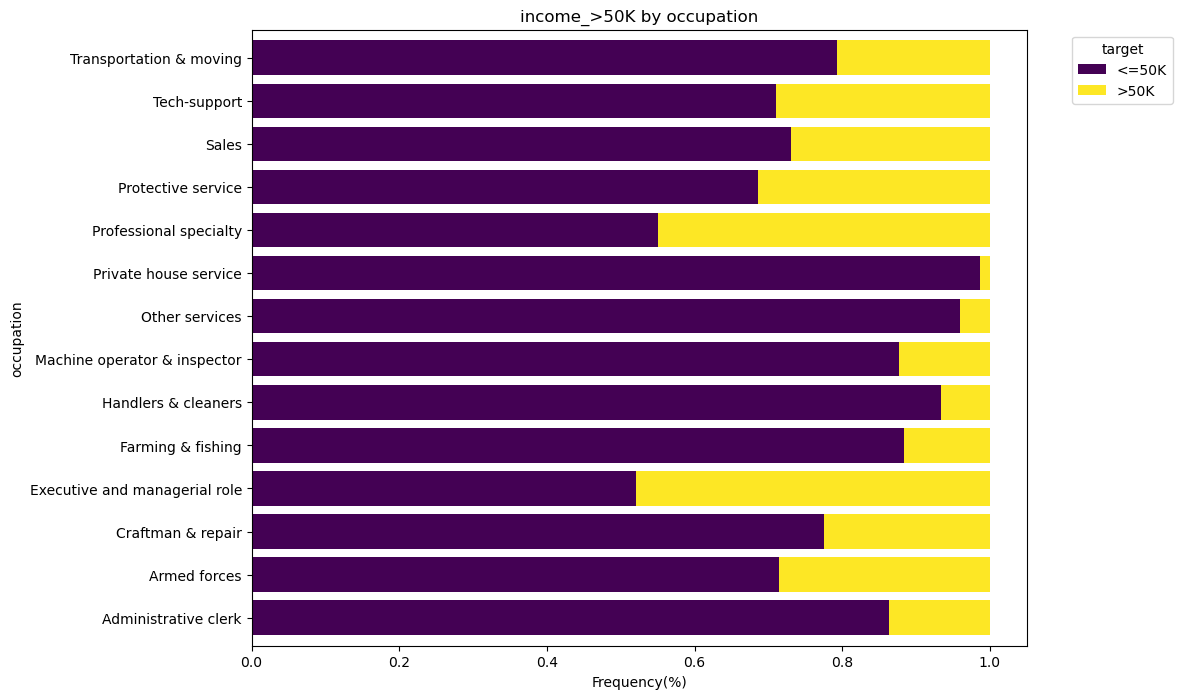

In [26]:
plot_stacked_bar_horizontal(full_data, 'occupation', palette='viridis')

**Insights**
  
- Executive and Managerial Roles have the highest percentage (47.9%) of individuals earning more than 50K, closely followed by Professional Specialty roles (45.0%).
- Private House Service has the lowest percentage (1.3%) of individuals earning more than 50K.
Occupations like Handlers & Cleaners, Other Services, and Farming & Fishing also have low percentages of individuals earning more than 50K.
                                                                                                                                                           
**Interpretation**

These percentages highlight the correlation between occupation and income levels. High-responsibility roles such as Executive and Managerial positions and Professional Specialties are associated with a higher likelihood of earning more than 50K. Conversely, roles in Private House Service, Handlers & Cleaners, and Other Services are associated with a lower likelihood of earning more than 50K.

### Relationship

In [27]:
value_cnt_norm_cal(full_data,'relationship')

,Count,Frequency (%)
relationship,,
Husband,18666,41.277283
Not in a family,11701,25.875147
Own child,6626,14.652484
Not married,4788,10.588001
Wife,2091,4.623958
Other relative,1349,2.983127


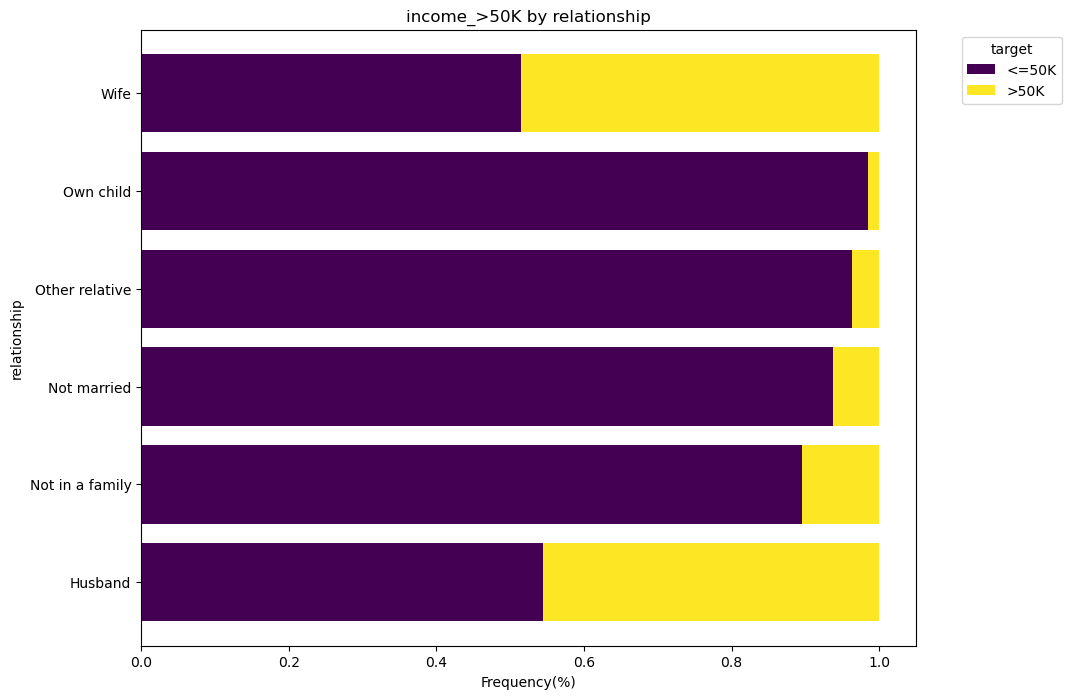

In [28]:
plot_stacked_bar_horizontal(full_data, 'relationship', palette='viridis')

**Insights**
  
- Wives have the highest percentage (48.6%) of earning more than 50K, closely followed by Husbands (45.6%).
- Own Child has the lowest percentage (1.6%) of individuals earning more than 50K, which is expected given their likely younger age and dependency status.
- Individuals Not in a Family, Not Married, and Other Relatives have relatively low percentages of earning more than 50K, with Not in a Family at 10.5%, Not Married at 6.3%, and Other Relatives at 3.7%.

**Interpretation**

These percentages highlight the correlation between relationship status and income levels. Being a Husband or Wife is associated with a higher likelihood of earning more than 50K. Conversely, individuals who are Not in a Family, Not Married, or Other Relatives tend to have a lower likelihood of earning more than 50K.

### Race

In [29]:
value_cnt_norm_cal(full_data,'race')

,Count,Frequency (%)
race,,
White,38902,86.026404
Black,4228,9.349638
Asian & pacific islander,1303,2.881405
American first nation,435,0.961942
Other,353,0.780611


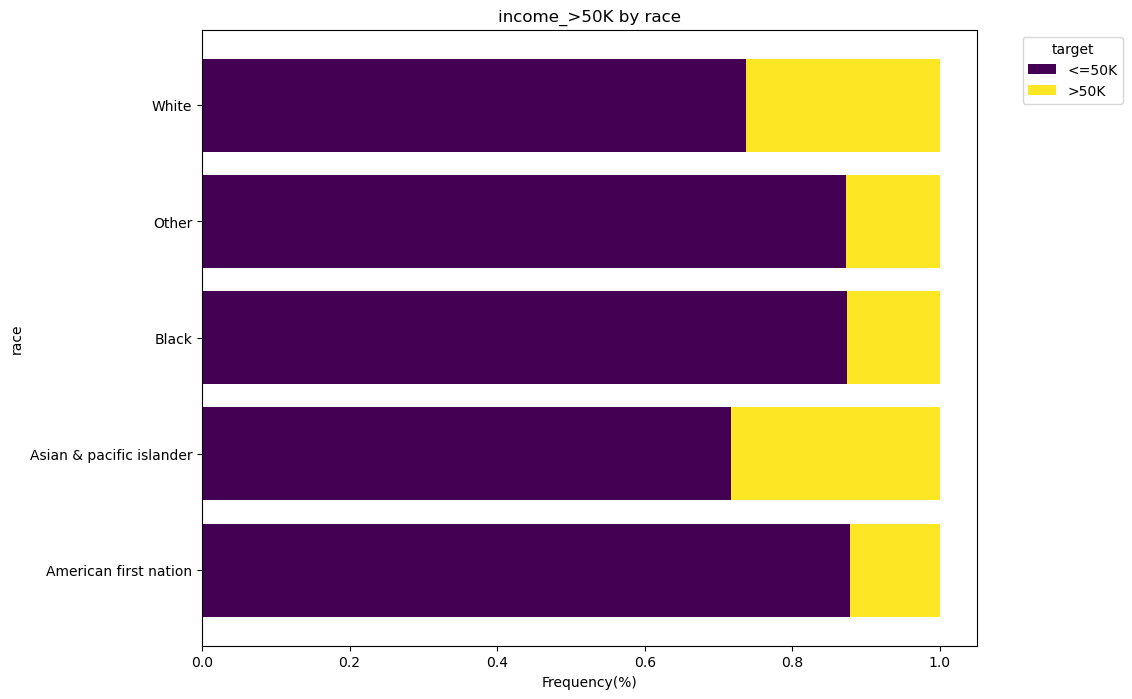

In [30]:
plot_stacked_bar_horizontal(full_data, 'race', palette='viridis')

**Insights**
  
- Asian & Pacific Islander individuals have the highest percentage (28.3%) of earning more than 50K.
- White individuals also have a relatively high percentage (26.2%) of earning more than 50K.
- American First Nation, Black, and Other races have similar and lower percentages of individuals earning more than 50K, with American First Nation at 12.2%, Black at 12.6%, and Other at 12.7%.

**Interpretation**
These percentages highlight the correlation between race and income levels. Asian & Pacific Islander and White individuals are more likely to earn more than 50K compared to other racial groups. Conversely, American First Nation, Black, and Other races have a lower likelihood of earning more than 50K.

### Gender

In [31]:
value_cnt_norm_cal(full_data,'gender')

,Count,Frequency (%)
gender,,
Male,30526,67.504036
Female,14695,32.495964


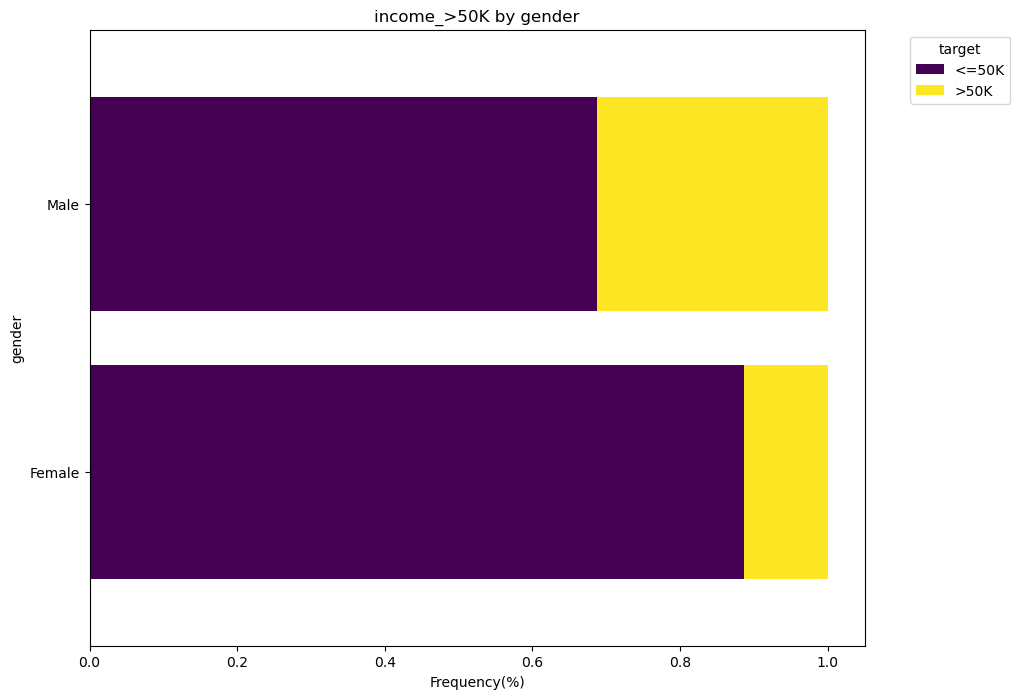

In [32]:
plot_stacked_bar_horizontal(full_data, 'gender', palette='viridis')

**Insights**
  
- Males have a higher percentage (31.2%) of earning more than 50K compared to Females (11.4%).
- A significant majority of Females (88.6%) earn less than 50K, while a smaller majority of Males (68.8%) earn less than 50K.

**Interpretation**
    
These percentages highlight the gender disparity in income levels. Males are more likely to earn more than 50K compared to Females. This could be due to various factors, including differences in occupation, work hours, and other socio-economic factors.

### Native country

In [33]:
value_cnt_norm_cal(full_data,'native-country')

,Count,Frequency (%)
native-country,,
United-States,41291,91.309347
Mexico,903,1.996860
Philippines,283,0.625815
Germany,193,0.426793
Puerto-Rico,175,0.386988
Canada,163,0.360452
El-Salvador,147,0.325070
India,147,0.325070
Cuba,133,0.294111


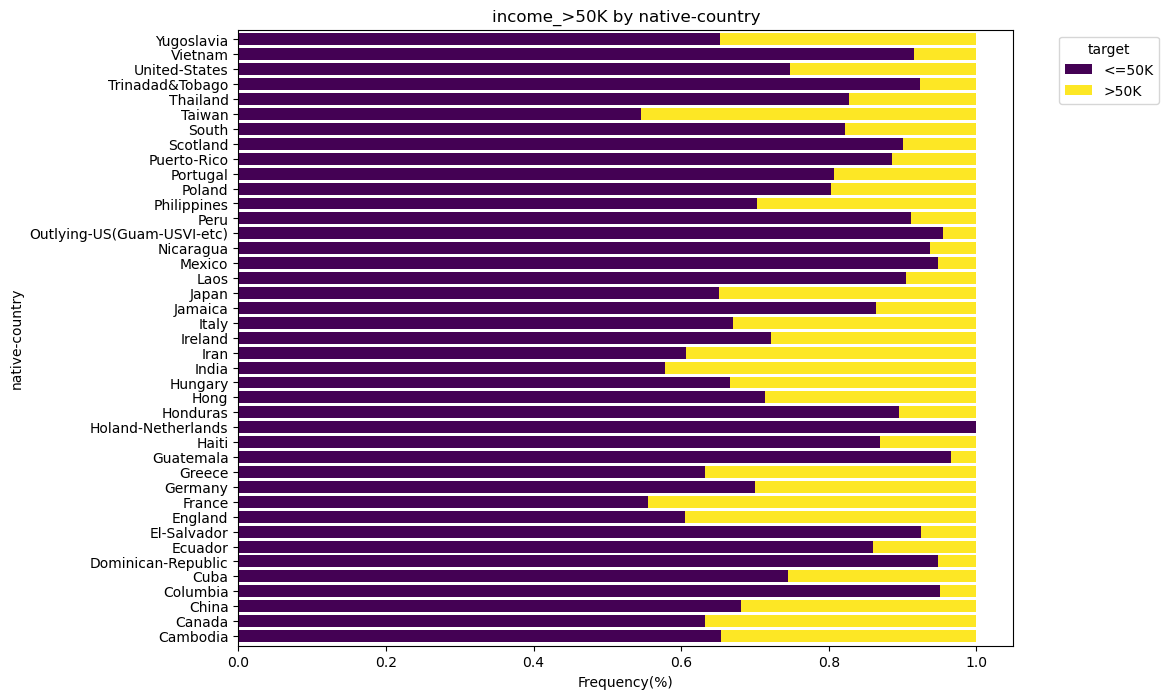

In [34]:
plot_stacked_bar_horizontal(full_data, 'native-country', palette='viridis')

**Insights**
  
- France has the highest percentage (44.4%) of individuals earning more than 50K, followed closely by Taiwan (45.5%) and India (42.2%).
- Holand-Netherlands has no individuals earning more than 50K in this dataset.
- Countries like Columbia, Dominican Republic, and Mexico have very low percentages of individuals earning more than 50K, with Columbia at 4.9%, Dominican Republic at 5.2%, and Mexico at 5.2%.

**Interpretation**
  
These percentages highlight the correlation between native country and income levels. Individuals from countries like France, Taiwan, and India are more likely to earn more than 50K compared to those from countries like Columbia, Dominican Republic, and Mexico.

### Age

In [35]:
full_data['age'].describe()

count    45221.000000
mean        38.547931
std         13.218016
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64

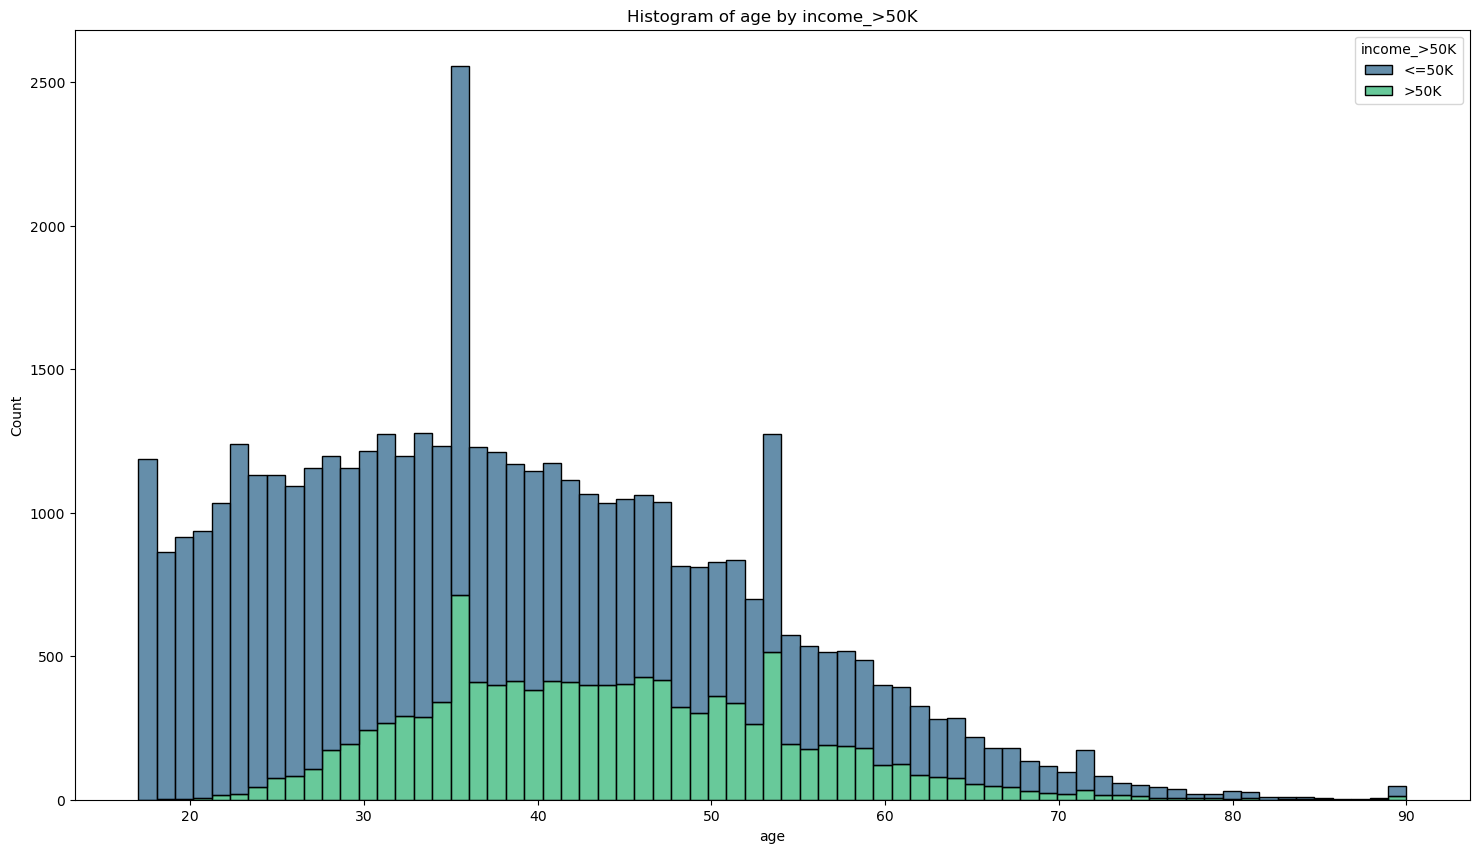

In [37]:
plot_histogram(full_data, 'age', palette='viridis')

**Insights**
  
Young Adults (17-24): Very few individuals earn more than 50K, which is expected given their likely early career stages.
Early to Mid-Career (25-39): A significant increase in the percentage of individuals earning more than 50K, reflecting career progression and increased earning potential.
Peak Earning Years (40-59): The highest percentages of individuals earning more than 50K, indicating peak earning potential during these ages.
Late Career to Retirement (60-90): A gradual decrease in the percentage of individuals earning more than 50K, likely due to retirement and reduced income.

**Interpretation**
    
These percentages highlight the correlation between age and income levels. As individuals progress in their careers, the likelihood of earning more than $50K increases, peaking during the mid-career years (40-59). After this peak, the likelihood decreases as individuals approach retirement age.

### Final weight

In [38]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
full_data['final-weight'].describe()

count     45221.000
mean     189737.216
std      105639.045
min       13492.000
25%      117392.000
50%      178319.000
75%      237928.000
max     1490400.000
Name: final-weight, dtype: float64

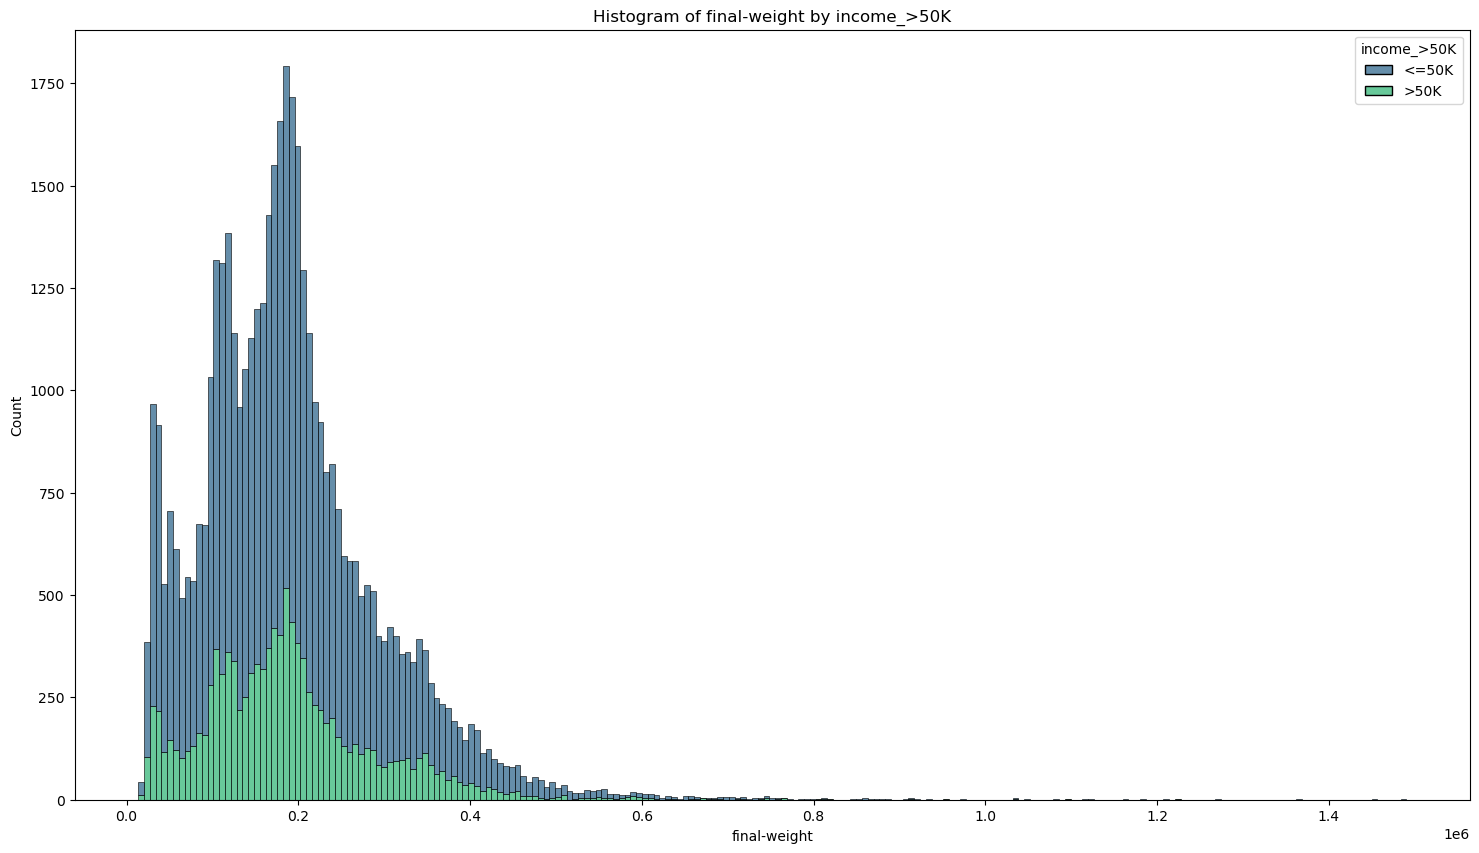

In [39]:
plot_histogram(full_data, 'final-weight', palette='viridis')

### Capital Gain

In [40]:
full_data['capital-gain'].describe()

count   45221.000
mean     1101.407
std      7506.511
min         0.000
25%         0.000
50%         0.000
75%         0.000
max     99999.000
Name: capital-gain, dtype: float64

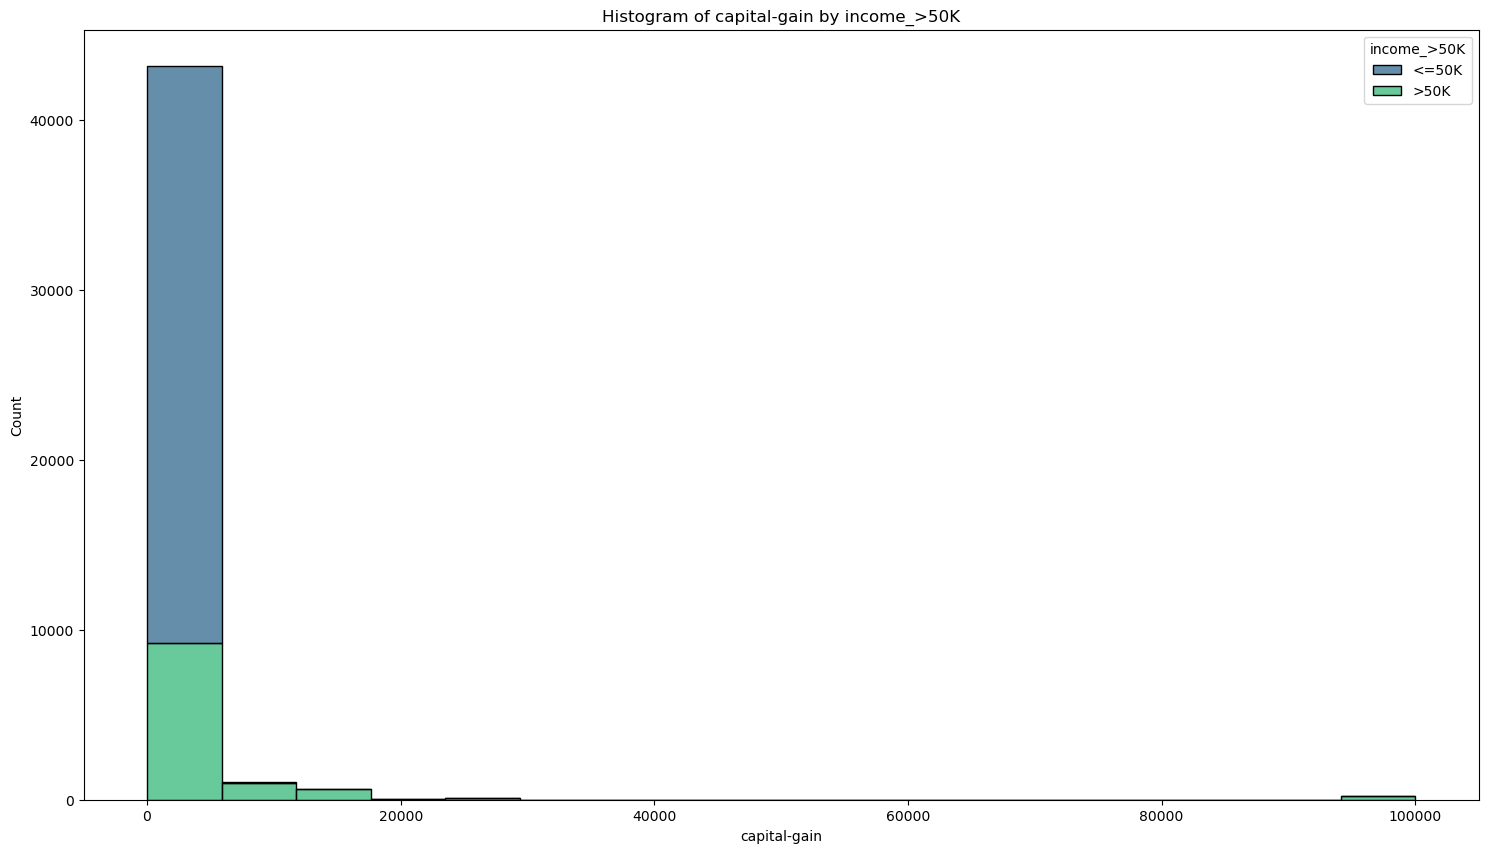

In [41]:
plot_histogram(full_data, 'capital-gain', palette='viridis', bins=100)

### Capital Loss

In [42]:
full_data['capital-loss'].describe()

count   45221.000
mean       88.597
std       404.960
min         0.000
25%         0.000
50%         0.000
75%         0.000
max      4356.000
Name: capital-loss, dtype: float64

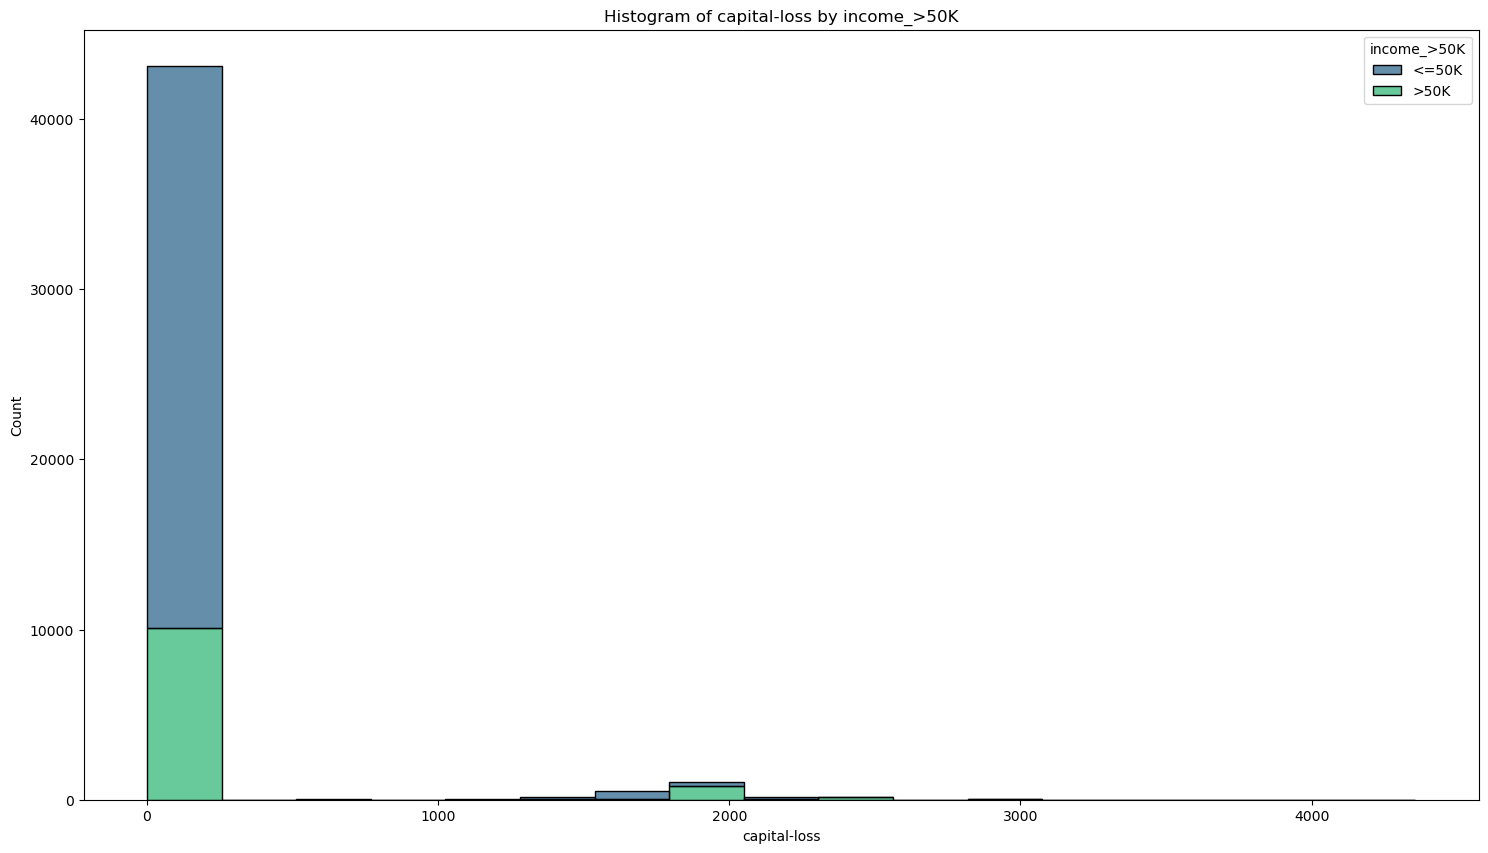

In [43]:
plot_histogram(full_data, 'capital-loss', palette='viridis', bins=100)

### Hours Per Week

In [44]:
full_data['hours-per-week'].describe()

count   45221.000
mean       40.938
std        12.008
min         1.000
25%        40.000
50%        40.000
75%        45.000
max        99.000
Name: hours-per-week, dtype: float64

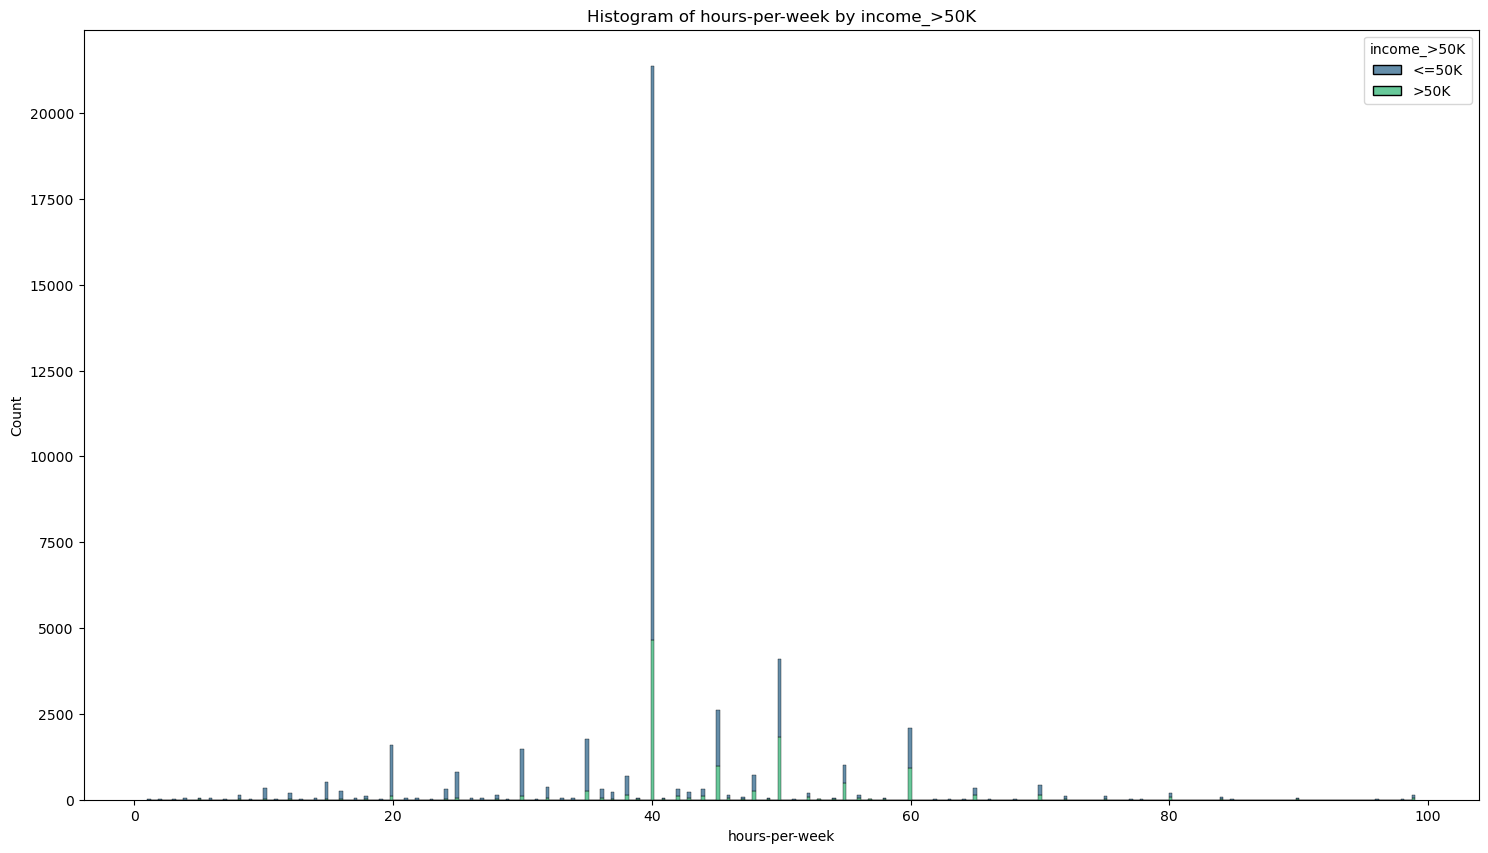

In [45]:
plot_histogram(full_data, 'hours-per-week', palette='viridis', bins=100)

**Insights**
  
- Low Hours (1-20): Very few individuals earn more than 50K, which is expected given the limited working hours.
- Moderate Hours (21-40): A gradual increase in the percentage of individuals earning more than 50K, reflecting increased earning potential with more hours worked.
- High Hours (41-60): The highest percentages of individuals earning more than 50K, indicating peak earning potential during these hours.
- Very High Hours (61-90): A decrease in the percentage of individuals earning more than 50K, likely due to the diminishing returns of working excessively long hours.

**Interpretation**

These percentages highlight the correlation between hours worked per week and income levels. As individuals work more hours, the likelihood of earning more than $50K increases, peaking around 50-55 hours per week. Beyond this point, the likelihood decreases, suggesting that working excessively long hours does not necessarily translate to higher income.

### Income > 50K (Target variable)

In [46]:
value_cnt_norm_cal(full_data,'income_>50K')

,Count,Frequency (%)
income_>50K,,
<=50K,34013,75.215
>50K,11208,24.785


**Insights**
  
- Majority Income Group: The majority of individuals (75.215%) earn less than or equal to 50K.
- Higher Income Group: A smaller portion (24.785%) earn more than 50K

**Conclusion**
  
The analysis reveals significant disparities in income levels based on demographic factors. Higher education, certain occupations, and working more hours per week are strongly associated with higher income levels. Conversely, lower education levels, certain occupations, and fewer working hours are associated with lower income levels.

### Scatter plots

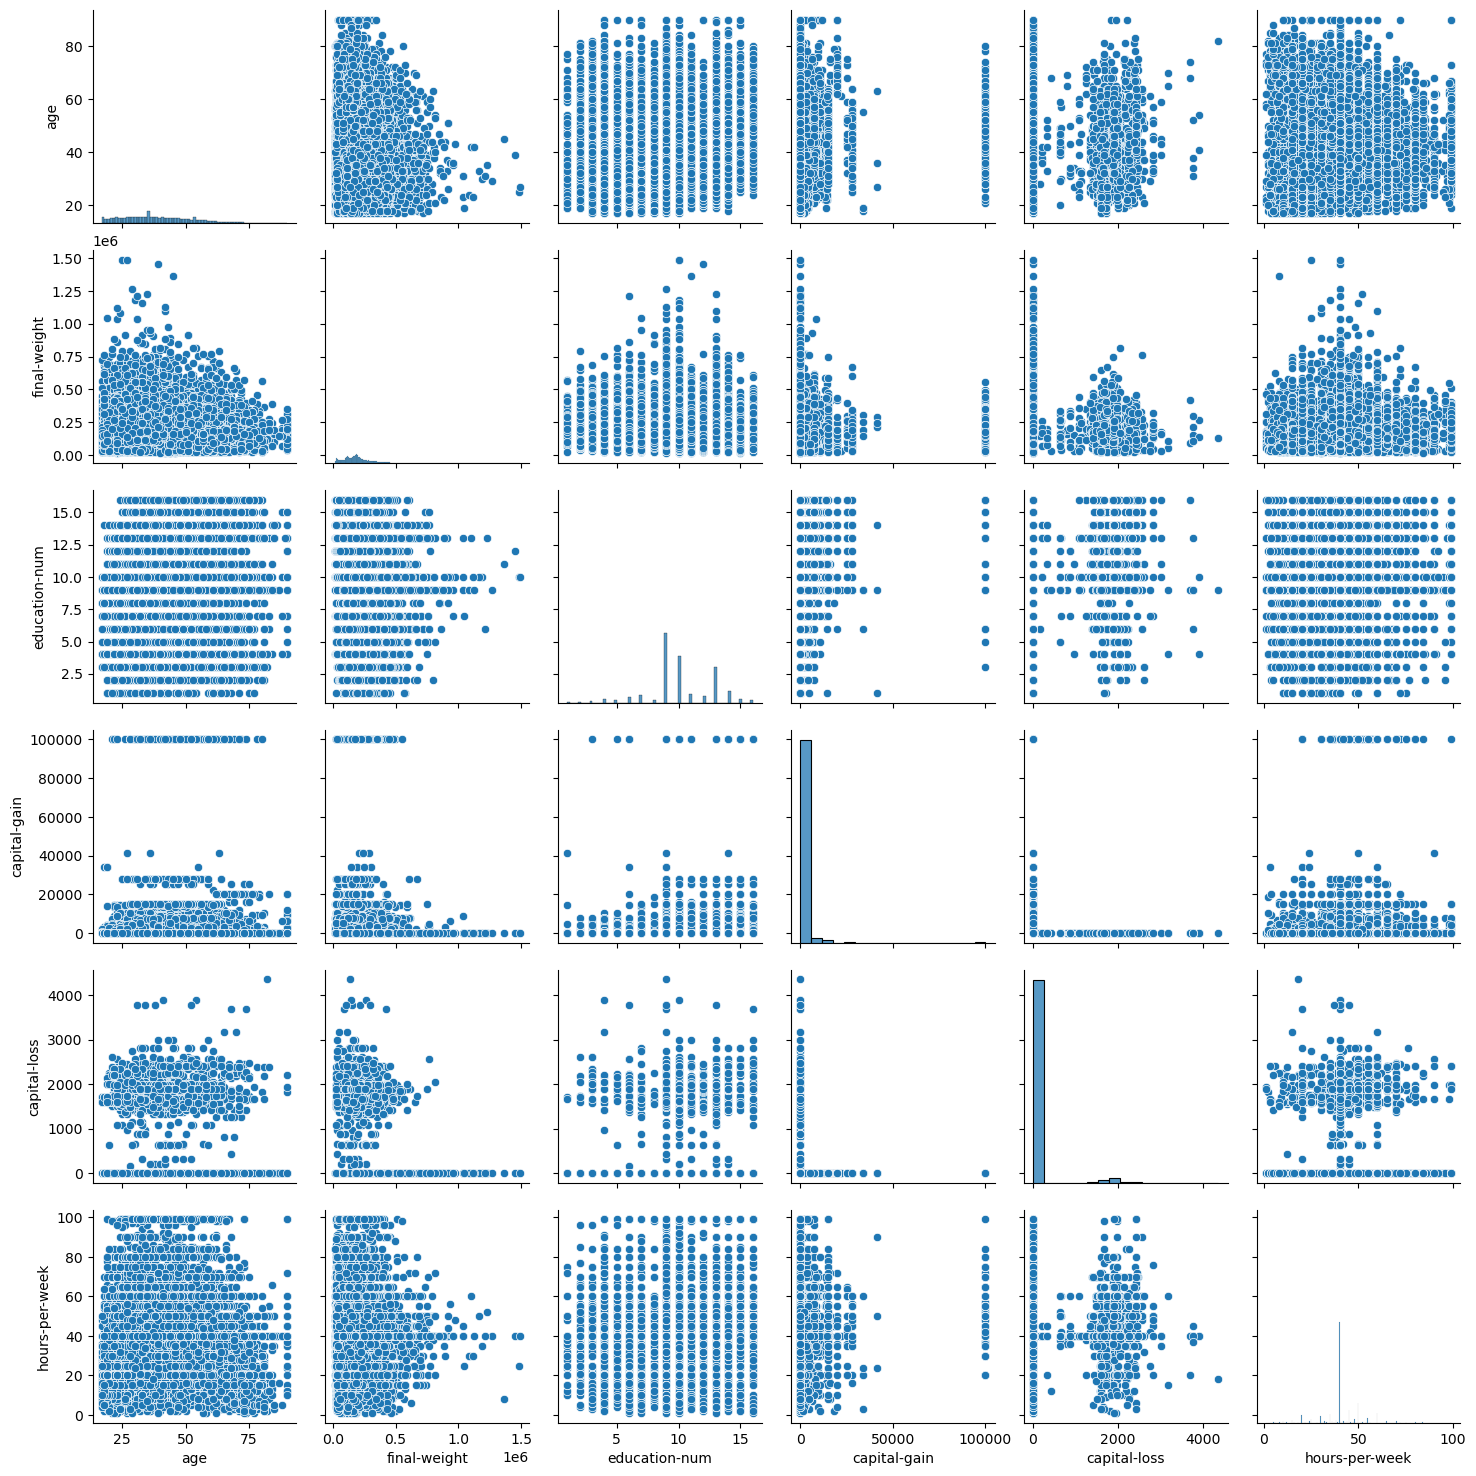

In [47]:
sns.pairplot(full_data)
plt.show()

### Age vs hours per week

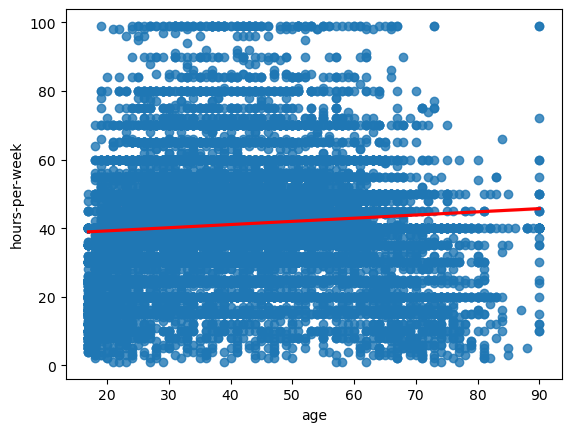

In [63]:
sns.regplot(x='age', y='hours-per-week', data=full_data, line_kws={'color': 'red'})
plt.show()

In [75]:
full_data.columns

Index(['age', 'work-class', 'final-weight', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income_>50K'],
      dtype='object')

### Correlation

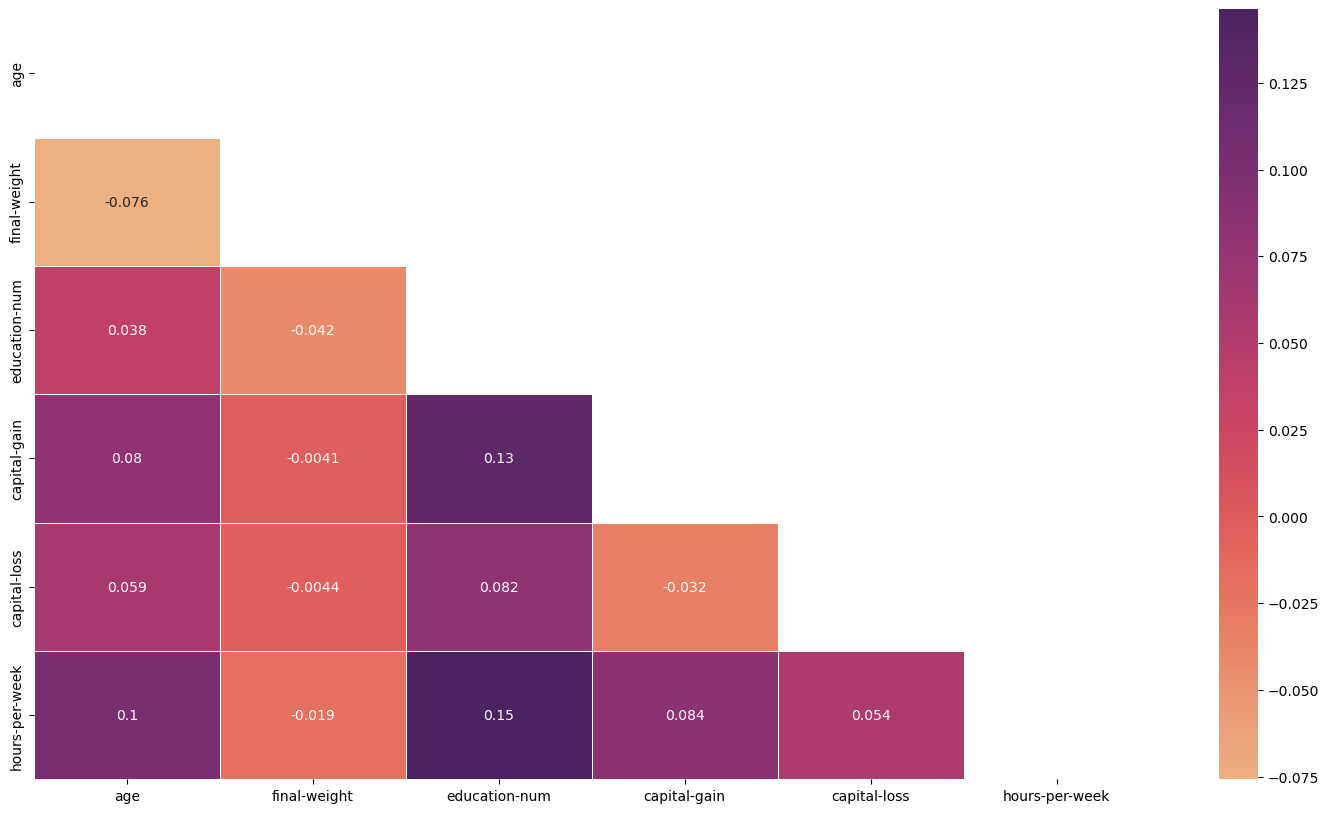

In [48]:
corr = full_data[['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].corr()

# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 10))

# Seaborn heatmap
sns.heatmap(corr, annot=True, cmap='flare', mask=mask, linewidths=.5)

# Create the 'images' directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Save the heatmap to the 'images' folder
plt.savefig('images/correlation_matrix.png')

# Plot the heatmap
plt.show()

# Prepare the data

## Remove outliers

In [14]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers=None):
        self.feat_with_outliers = feat_with_outliers or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_features = set(self.feat_with_outliers) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        # Calculate 25% and 75% quantiles
        Q1 = X[self.feat_with_outliers].quantile(0.25)
        Q3 = X[self.feat_with_outliers].quantile(0.75)
        IQR = Q3 - Q1

        # Keep data within 3 IQR
        X = X[~((X[self.feat_with_outliers] < (Q1 - 3 * IQR)) | (X[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
        return X

## Fix skewness

In [15]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self, col_with_skewness=None):

        self.col_with_skewness = col_with_skewness or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        missing_features = set(self.col_with_skewness) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        X[self.col_with_skewness] = np.cbrt(X[self.col_with_skewness])
        return X

## Oversampling with SMOTE

In [16]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'income_>50K' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'income_>50K'],df['income_>50K'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("income_>50K is not in the dataframe")
            return df

## Drop features

In [17]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_drop=None):

        self.feature_to_drop = feature_to_drop or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        missing_features = set(self.feature_to_drop) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")
        return X.drop(columns=self.feature_to_drop)

## Ordinal encoding

In [18]:
class OrdinalEncoderWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_enc_ft=None):

        self.ordinal_enc_ft = ordinal_enc_ft or []
        self.ordinal_enc = OrdinalEncoder()

    def fit(self, X, y=None):

        self.ordinal_enc.fit(X[self.ordinal_enc_ft])
        return self

    def transform(self, X):

        missing_features = set(self.ordinal_enc_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        ordinal_enc_df = pd.DataFrame(self.ordinal_enc.transform(X[self.ordinal_enc_ft]), columns=self.ordinal_enc_ft, index=X.index)
        rest_of_features = [ft for ft in X.columns if ft not in self.ordinal_enc_ft]
        df_concat = pd.concat([ordinal_enc_df, X[rest_of_features]], axis=1)
        return df_concat

## One hot encoding

In [19]:
class OneHotWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc_ft=None):
        self.one_hot_enc_ft = one_hot_enc_ft or []
        self.one_hot_enc = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        self.one_hot_enc.fit(X[self.one_hot_enc_ft])
        self.feat_names_one_hot_enc = self.one_hot_enc.get_feature_names_out(self.one_hot_enc_ft)
        return self

    def transform(self, X):
        missing_features = set(self.one_hot_enc_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        one_hot_enc_df = pd.DataFrame(self.one_hot_enc.transform(X[self.one_hot_enc_ft]).toarray(), columns=self.feat_names_one_hot_enc, index=X.index)
        rest_of_features = [ft for ft in X.columns if ft not in self.one_hot_enc_ft]
        df_concat = pd.concat([one_hot_enc_df, X[rest_of_features]], axis=1)
        return df_concat

## Frequency encoding

In [20]:
class FrequencyEncoderWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, freq_enc_ft=None):
        self.freq_enc_ft = freq_enc_ft or []
        self.freq_enc_map = {}

    def fit(self, X, y=None):
        for feature in self.freq_enc_ft:
            freq = X[feature].value_counts() / len(X)
            self.freq_enc_map[feature] = freq
        return self

    def transform(self, X):
        missing_features = set(self.freq_enc_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        freq_enc_df = X[self.freq_enc_ft].apply(lambda col: col.map(self.freq_enc_map[col.name]))
        rest_of_features = [ft for ft in X.columns if ft not in self.freq_enc_ft]
        df_concat = pd.concat([freq_enc_df, X[rest_of_features]], axis=1)
        return df_concat

## Min-Max Scalling

In [21]:
class MinMaxWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, min_max_scaler_ft=None):

        self.min_max_scaler_ft = min_max_scaler_ft or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        missing_features = set(self.min_max_scaler_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        min_max_enc = MinMaxScaler()
        X[self.min_max_scaler_ft] = min_max_enc.fit_transform(X[self.min_max_scaler_ft])
        return X

## Binning

In [22]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['income_>50K']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to No and 1 to Yes for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({'<=50K':0, '>50K':1})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [23]:
full_data['income_>50K'].value_counts()

income_>50K
<=50K    34013
>50K     11208
Name: count, dtype: int64

## Data preprocessing

In [24]:
# Create the pipeline
pipeline = Pipeline([
    ('outlier remover', OutlierRemover(feat_with_outliers=['age'])),
    ('skewness transformer', SkewnessHandler(col_with_skewness=['age','capital-gain','capital-loss'])),
    ('binning_num_to_yn', BinningNumToYN()),
    ('drop features', DropFeatures(feature_to_drop=['final-weight', 'relationship', 'education-num'])),
    ('frequency encoding', FrequencyEncoderWithFeatNames(freq_enc_ft=['native-country'])),
    ('ordinal encoding', OrdinalEncoderWithFeatNames(ordinal_enc_ft=['education'])),
    ('one hot encoding', OneHotWithFeatNames(one_hot_enc_ft=['race', 'gender', 'work-class', 'occupation','marital-status'])),
    ('min max scaler', MinMaxWithFeatNames(min_max_scaler_ft=['age','capital-gain','capital-loss', 'hours-per-week'])),
    ('oversample', Oversample())
])

In [25]:
# train_copy.columns

In [26]:
# Apply the pipeline to the DataFrame
train_pipe_prep = pipeline.fit_transform(train_copy)

In [55]:
# # Apply the pipeline to the DataFrame
# test_pipe_prep = pipeline.fit_transform(test_copy)

In [27]:
pd.set_option('display.max_columns', None)
train_pipe_prep.head()

,race_American first nation,race_Asian & pacific islander,race_Black,race_Other,race_White,gender_Female,gender_Male,work-class_Federal government,work-class_Local government,work-class_Private sector,work-class_Self employed (incorporated),work-class_Self employed (not incorporated),work-class_State governemnt,work-class_Without work,occupation_Administrative clerk,occupation_Armed forces,occupation_Craftman & repair,occupation_Executive and managerial role,occupation_Farming & fishing,occupation_Handlers & cleaners,occupation_Machine operator & inspector,occupation_Other services,occupation_Private house service,occupation_Professional specialty,occupation_Protective service,occupation_Sales,occupation_Tech-support,occupation_Transportation & moving,marital-status_Divorced,marital-status_Married (abscent spouse),marital-status_Married (armed forces spouse),marital-status_Married (civilian spouse),marital-status_Never married,marital-status_Separated,marital-status_Widowed,education,native-country,age,capital-gain,capital-loss,hours-per-week,income_>50K
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0,0.91370,0.668658,0.0,0.0,0.397959,0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.91370,0.204811,0.0,0.0,0.397959,0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,0.91370,0.025894,0.0,0.0,0.112245,0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,0.00188,0.098236,0.0,0.0,0.397959,0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.91370,0.595327,0.0,0.0,0.377551,0


In [28]:
# split the train data into X and y (target)
X_train, y_train = train_pipe_prep.loc[:, train_pipe_prep.columns != 'income_>50K'], train_pipe_prep['income_>50K']

# Model Training

## Function to evaluate the models and all the metrics

In [29]:
def evaluate_models(model_list, X_train, y_train, scoring):
    # Dictionary to store trained models
    trained_models = {}

    # Create the 'images' directory if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')

    for model in model_list:
        # Fit the model
        model.fit(X_train, y_train)

        # Print model name
        print(str(model))
        
        # Perform cross-validation and print scores
        cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=scoring, return_estimator=True)
        for score in scoring:
            print(f'{score.capitalize()} scores: {cv_results["test_" + score]}')
            print(f'Mean {score.capitalize()}: {cv_results["test_" + score].mean():.10}\n')
        
        # Store the trained model (using the last estimator from cross-validation)
        trained_models[str(model)] = cv_results['estimator'][-1]
        
        # Generate cross-validated predictions and classification report on the training set
        if hasattr(model, 'predict_proba'):
            y_train_pred = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1)[:, 1]
        else:
            y_train_pred = cross_val_predict(model, X_train, y_train, cv=5, method='decision_function', n_jobs=-1)
            y_train_pred = (y_train_pred - y_train_pred.min()) / (y_train_pred.max() - y_train_pred.min())  # Normalize to [0, 1]
        
        print(f'Classification Report for {str(model)} on Training Set:\n')
        print(classification_report(y_train, y_train_pred > 0.5))
        
        # Plot confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred > 0.5, cmap='Blues', values_format='d')
        plt.title(f'Confusion Matrix for {str(model)} on Training Set')
        plt.savefig(f'images/{str(model)}_confusion_matrix.png', bbox_inches='tight')
        plt.show()
        
        # Get feature importances or coefficients
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]
        else:
            importances = np.zeros(X_train.shape[1])
        
        # Get feature names
        feature_names = X_train.columns
        
        # Get indices of top 10 and bottom 10 features
        indices = np.argsort(importances)
        top_10_indices = indices[-10:]
        bottom_10_indices = indices[:10]
        
        # Plot top 10 features
        plt.figure(figsize=(10, 4))
        plt.barh(range(len(top_10_indices)), importances[top_10_indices], align='center', color='skyblue')
        plt.yticks(range(len(top_10_indices)), [feature_names[i] for i in top_10_indices])
        plt.xlabel('Importance')
        plt.title(f'Top 10 Features for {str(model)}')
        plt.savefig(f'images/{str(model)}_top_10_features.png', bbox_inches='tight')
        plt.show()
        
        # Plot bottom 10 features
        plt.figure(figsize=(10, 4))
        plt.barh(range(len(bottom_10_indices)), importances[bottom_10_indices], align='center', color='salmon')
        plt.yticks(range(len(bottom_10_indices)), [feature_names[i] for i in bottom_10_indices])
        plt.xlabel('Importance')
        plt.title(f'Bottom 10 Features for {str(model)}')
        plt.savefig(f'images/{str(model)}_bottom_10_features.png', bbox_inches='tight')
        plt.show()
        
        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_train, y_train_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(f'images/{str(model)}_roc_curve.png', bbox_inches='tight')
        plt.show()
        
        print('\n')

    return trained_models

## Models comparison

In [30]:
model_list = [
    SGDClassifier(random_state=42,loss='huber'),
    LogisticRegression(random_state=42,max_iter=1000),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GaussianNB(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
]

SGDClassifier(loss='huber', random_state=42)
Precision scores: [0.70791323 0.72045665 0.71498621 0.7202711  0.72198667 0.7163185
 0.72435703 0.72186837 0.71855393 0.71245812]
Mean Precision: 0.717916981

Recall scores: [0.84996332 0.8565664  0.85614679 0.85798165 0.87486239 0.86825688
 0.87820983 0.8730741  0.88224505 0.85803375]
Mean Recall: 0.865534015

F1 scores: [0.77246208 0.78263784 0.77922512 0.78311841 0.79110669 0.78500332
 0.79389819 0.79030384 0.7920303  0.77849892]
Mean F1: 0.784828469

Accuracy scores: [0.74963316 0.76210565 0.75747569 0.76242891 0.7690332  0.76224546
 0.77196845 0.76829939 0.76829939 0.75582462]
Mean Accuracy: 0.7627313935

Roc_auc scores: [0.85917497 0.86840768 0.87667322 0.87759785 0.87886334 0.87184725
 0.86762821 0.87177159 0.8701952  0.8694694 ]
Mean Roc_auc: 0.8711628708

Classification Report for SGDClassifier(loss='huber', random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.83      0.66   

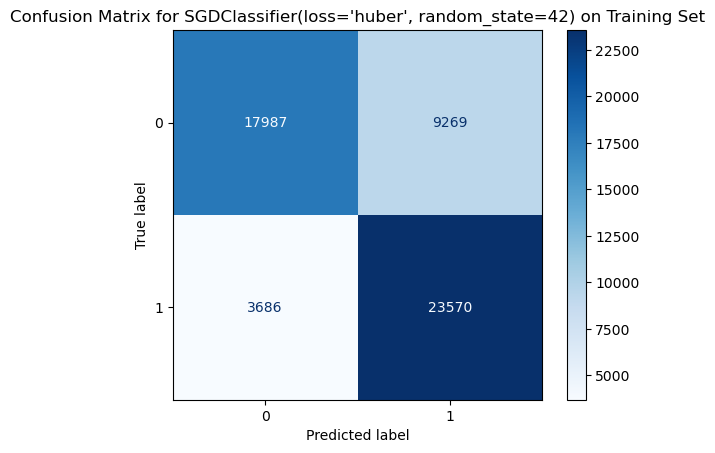

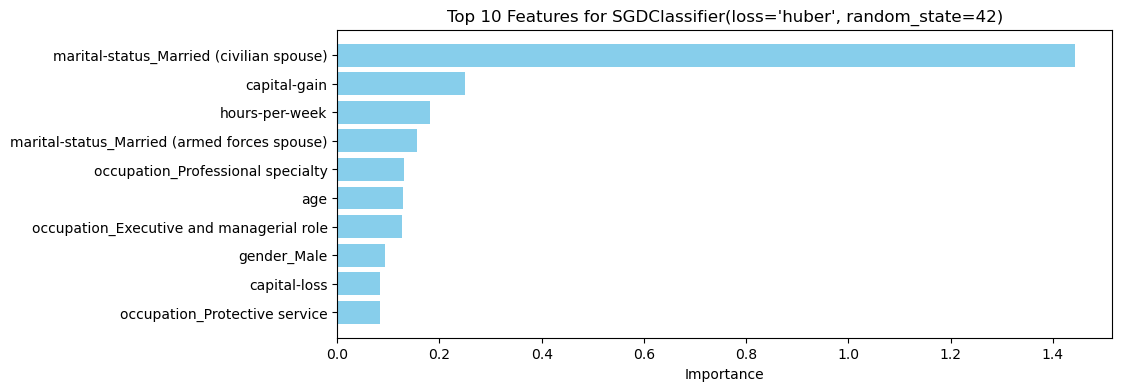

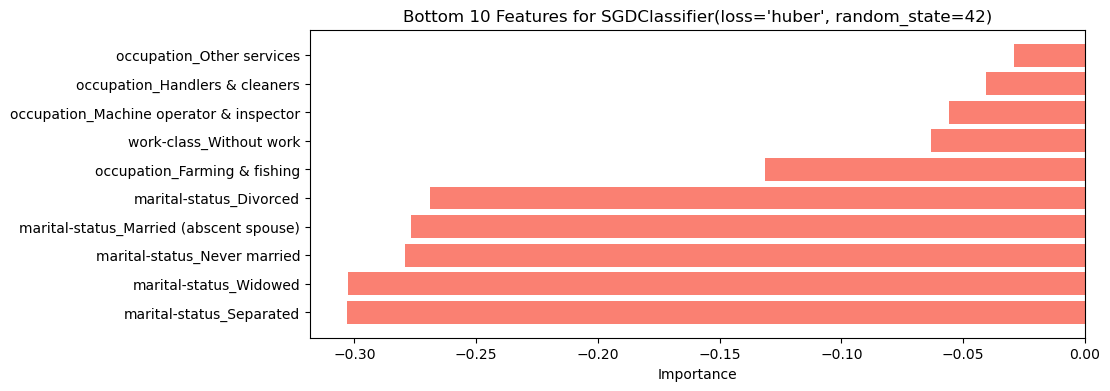

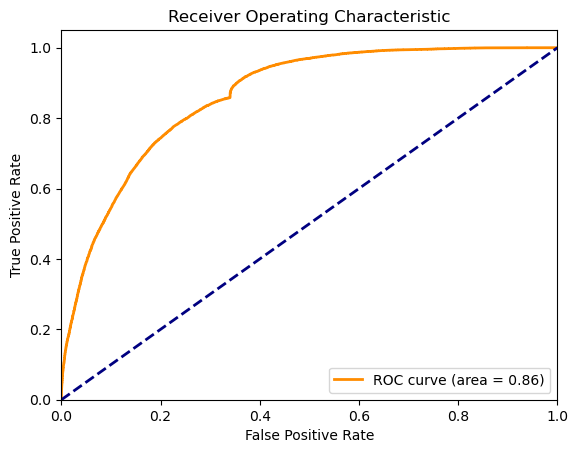



LogisticRegression(max_iter=1000, random_state=42)
Precision scores: [0.78285313 0.7921527  0.79603399 0.80662393 0.79872431 0.79923452
 0.7941693  0.80642882 0.79644475 0.79134682]
Mean Precision: 0.7964012287

Recall scores: [0.81731475 0.82208364 0.82495413 0.83119266 0.82715596 0.84293578
 0.8294204  0.83749083 0.8382245  0.83198826]
Mean Recall: 0.8302760909

F1 scores: [0.79971285 0.80684068 0.81023608 0.81872402 0.81269154 0.82050366
 0.81141217 0.82166637 0.81680071 0.8111588 ]
Mean F1: 0.8129746884

Accuracy scores: [0.79530448 0.80319149 0.80682444 0.81599706 0.80939277 0.81563016
 0.80719134 0.8181985  0.81196111 0.80627408]
Mean Accuracy: 0.808996542

Roc_auc scores: [0.87923532 0.88516367 0.88896895 0.89513485 0.8948218  0.89409108
 0.89012351 0.89920635 0.89724158 0.89149205]
Mean Roc_auc: 0.8915479178

Classification Report for LogisticRegression(max_iter=1000, random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       

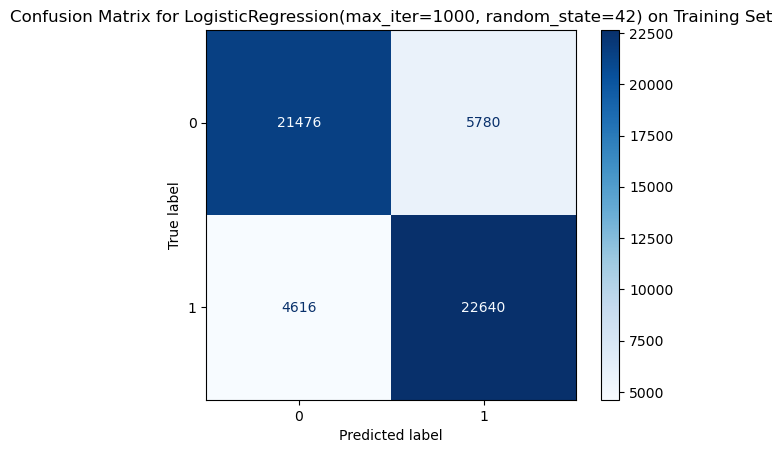

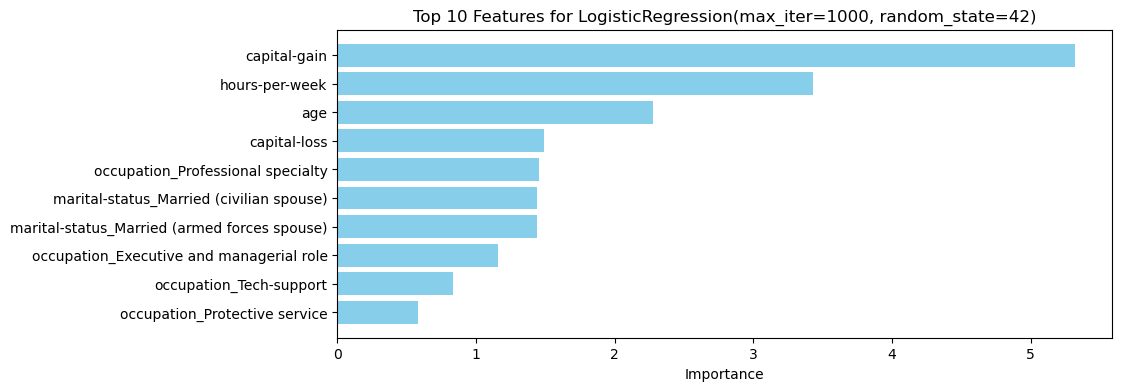

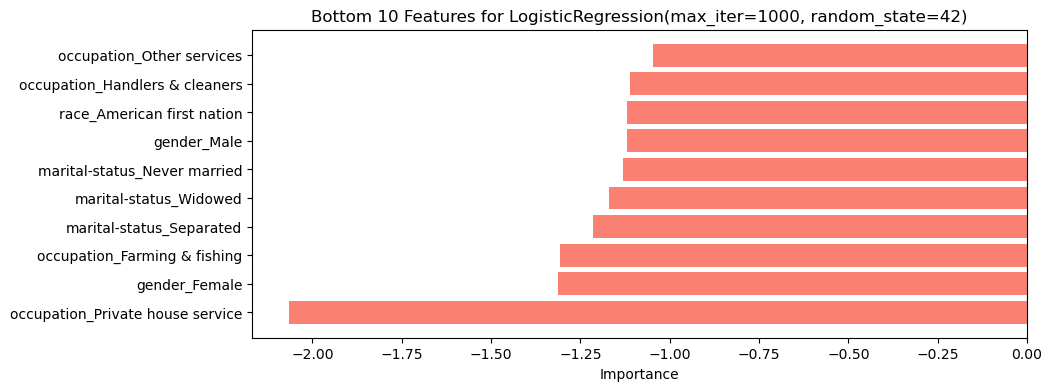

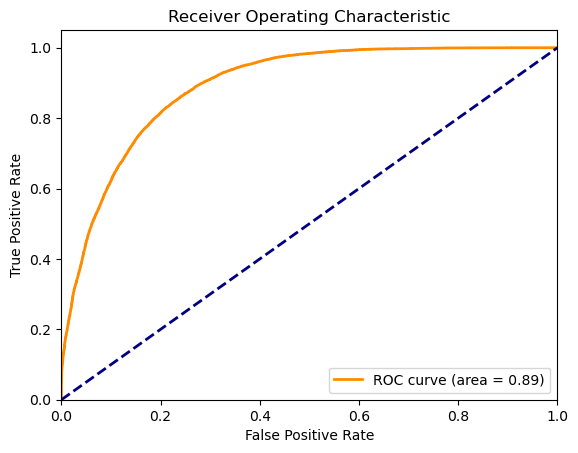



DecisionTreeClassifier(random_state=42)
Precision scores: [0.83273703 0.82886216 0.84222526 0.85583608 0.8649789  0.86302318
 0.87051862 0.86460891 0.85963115 0.86298497]
Mean Precision: 0.8545406262

Recall scores: [0.68305209 0.65737344 0.67779817 0.85834862 0.90275229 0.91559633
 0.91746148 0.90425532 0.92333089 0.90572267]
Mean Recall: 0.8345691304

F1 scores: [0.75050383 0.73322422 0.75111834 0.85709051 0.88346202 0.88853276
 0.89337382 0.88398781 0.89034312 0.88383748]
Mean F1: 0.8415473911

Accuracy scores: [0.77292737 0.76082172 0.77545405 0.85690699 0.88093928 0.88515869
 0.89047881 0.88130618 0.8862594  0.88093928]
Mean Accuracy: 0.8471191754

Roc_auc scores: [0.78552076 0.77343866 0.78816581 0.87040043 0.89249376 0.89788506
 0.90095526 0.89323585 0.89667113 0.89297967]
Mean Roc_auc: 0.8591746387

Classification Report for DecisionTreeClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.83      0.86      0

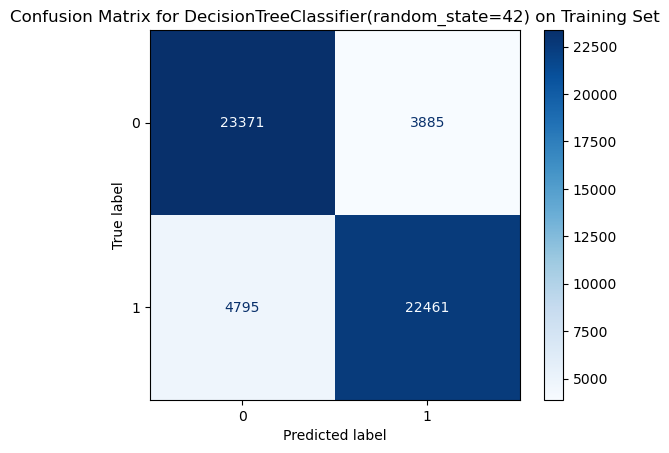

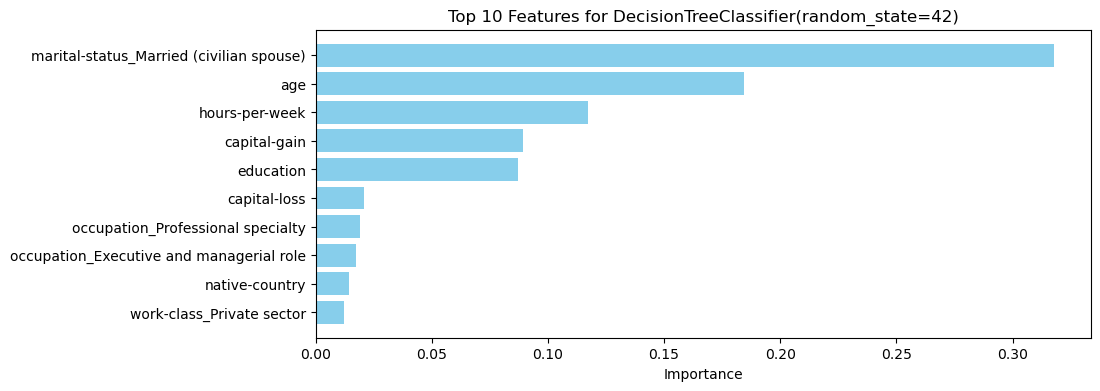

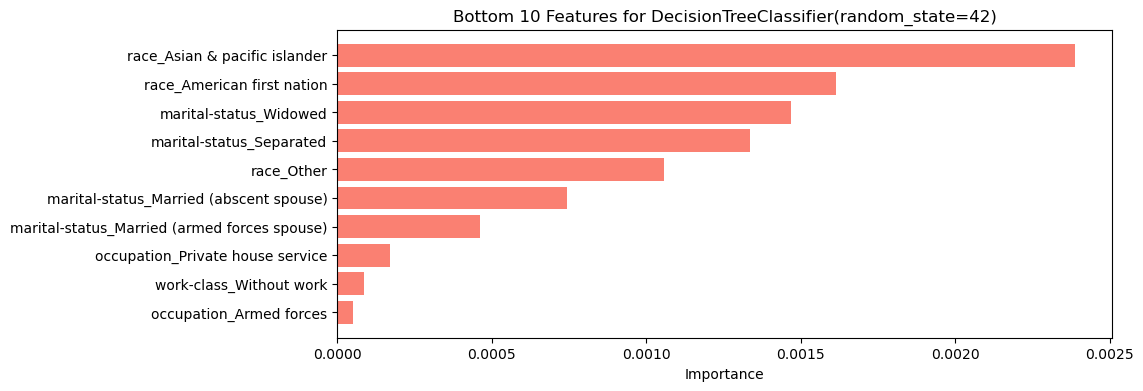

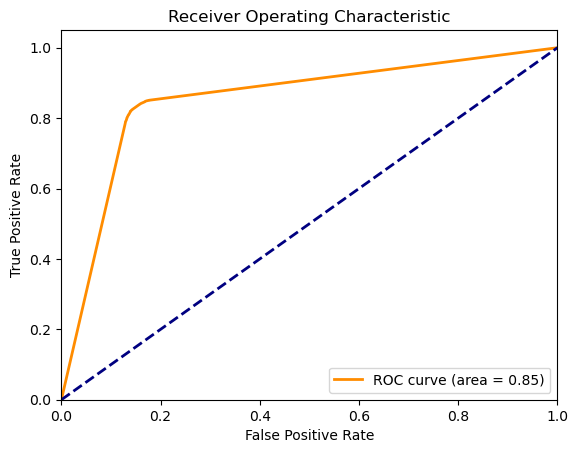



RandomForestClassifier(random_state=42)
Precision scores: [0.85903814 0.8616799  0.86578293 0.87540279 0.88154742 0.87729436
 0.88412753 0.88668264 0.88786325 0.88166895]
Mean Precision: 0.8761087906

Recall scores: [0.76008804 0.75641966 0.76697248 0.89724771 0.94495413 0.94715596
 0.94607483 0.95011005 0.95267792 0.945708  ]
Mean Recall: 0.8867408779

F1 scores: [0.80653951 0.8056261  0.81338782 0.88619065 0.91215019 0.91088759
 0.91405281 0.91730122 0.91912936 0.91256637]
Mean F1: 0.8797831625

Accuracy scores: [0.81768158 0.81749817 0.82406898 0.88479178 0.90900752 0.90735645
 0.9110255  0.91432765 0.91616217 0.90937443]
Mean Accuracy: 0.8811294225

Roc_auc scores: [0.90708768 0.9096538  0.91455909 0.953147   0.96586591 0.96861867
 0.96731892 0.96581933 0.96812744 0.96496113]
Mean Roc_auc: 0.948515896

Classification Report for RandomForestClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.88      0.87      0.

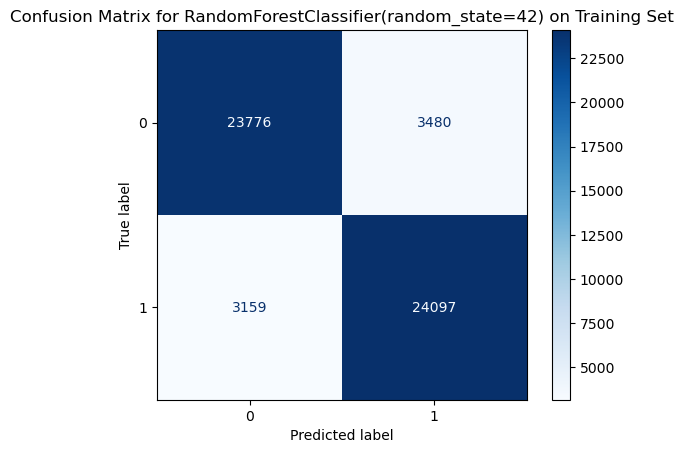

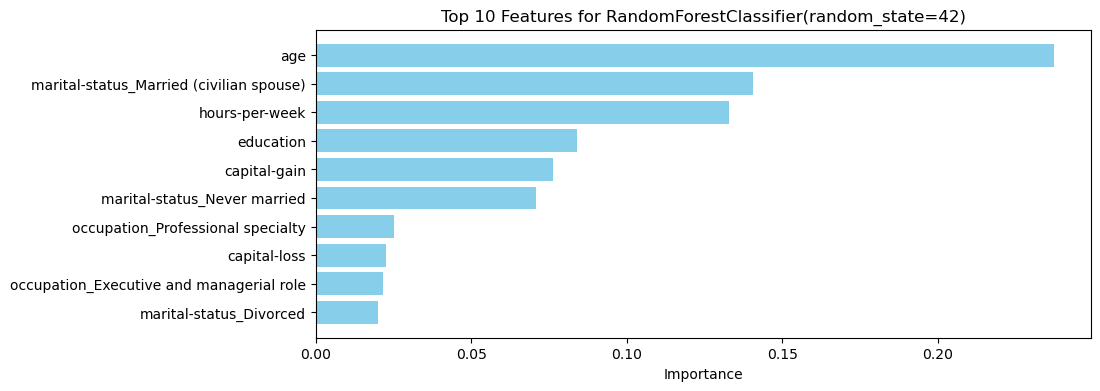

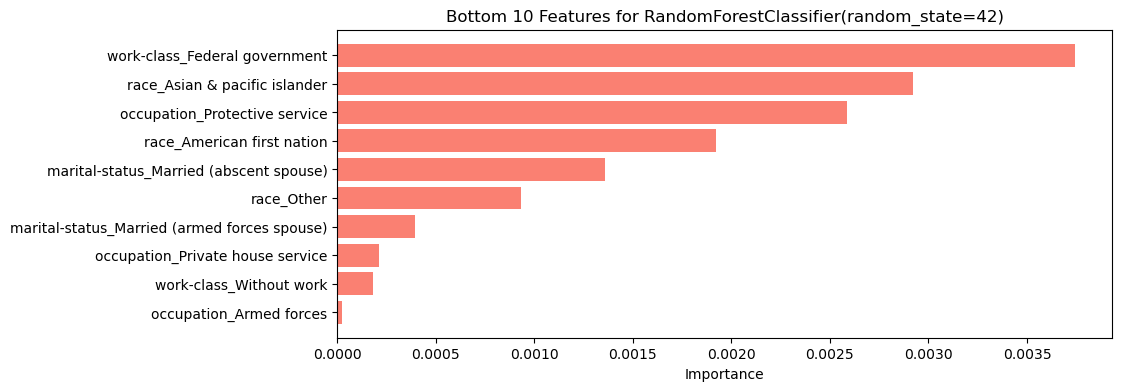

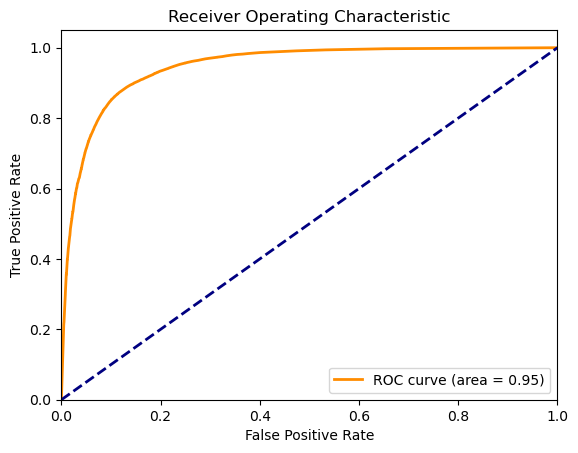



GaussianNB()
Precision scores: [0.71033265 0.72333433 0.70979021 0.74077435 0.73021583 0.72274882
 0.72245384 0.72898032 0.72315883 0.73552712]
Mean Precision: 0.7247316288

Recall scores: [0.88517975 0.88811445 0.89394495 0.8987156  0.89394495 0.89541284
 0.88994864 0.89691856 0.89691856 0.88554659]
Mean Recall: 0.8924644908

F1 scores: [0.78817573 0.79729952 0.79129446 0.81213729 0.80382775 0.79986887
 0.79750164 0.80427632 0.80072048 0.80359521]
Mean F1: 0.7998697281

Accuracy scores: [0.76210565 0.7742113  0.76426344 0.79214823 0.78187489 0.7760044
 0.77398642 0.78169143 0.77673821 0.78352596]
Mean Accuracy: 0.7766549933

Roc_auc scores: [0.84013836 0.84235251 0.8498983  0.86532729 0.8577353  0.8568977
 0.85042715 0.859665   0.85869365 0.85964124]
Mean Roc_auc: 0.8540776489

Classification Report for GaussianNB() on Training Set:

              precision    recall  f1-score   support

           0       0.86      0.66      0.75     27256
           1       0.72      0.89      0.8

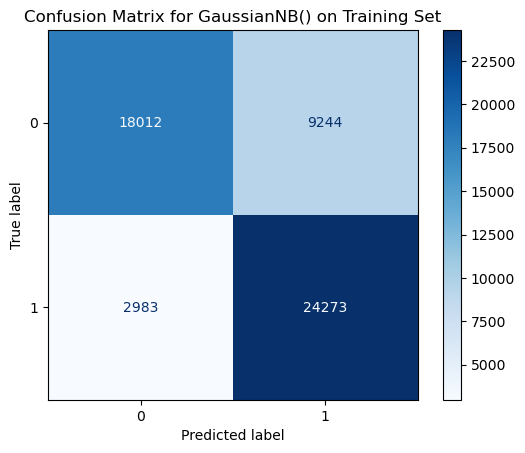

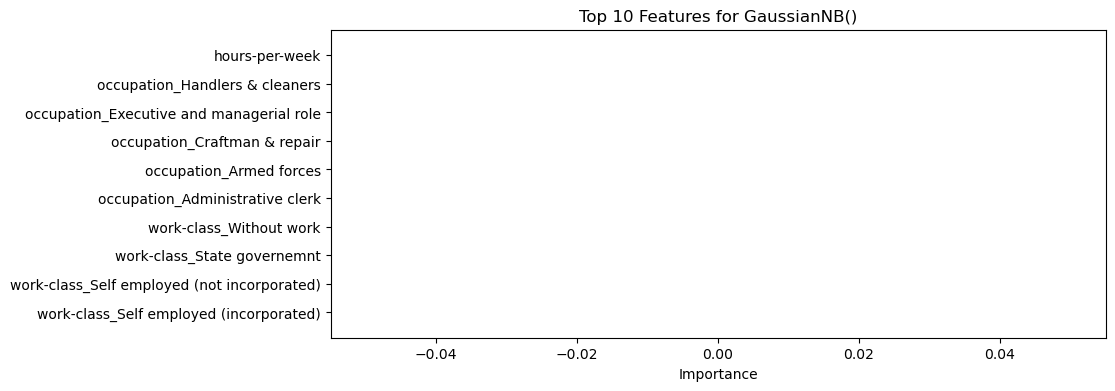

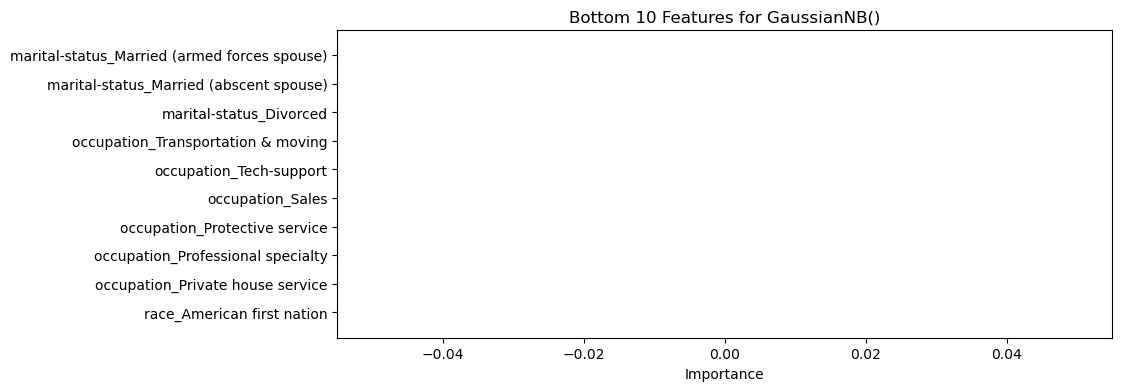

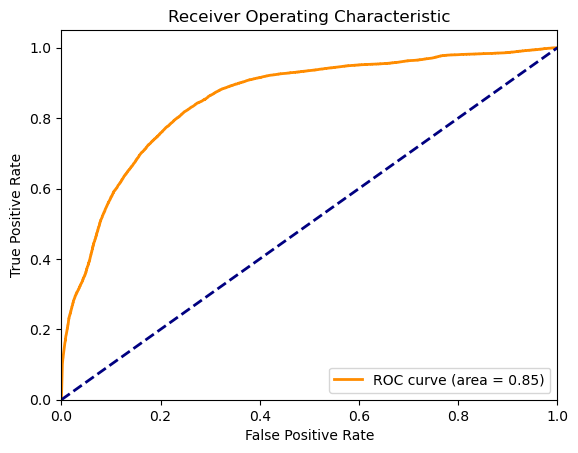



KNeighborsClassifier()
Precision scores: [0.79382159 0.79881036 0.8        0.81063123 0.81029363 0.81848185
 0.81483913 0.82019136 0.81081967 0.81064111]
Mean Precision: 0.8088529928

Recall scores: [0.83895818 0.83749083 0.84256881 0.89541284 0.9012844  0.91009174
 0.91049156 0.91195891 0.90719002 0.89985326]
Mean Recall: 0.8855300571

F1 scores: [0.81576601 0.81769341 0.8207328  0.85091543 0.8533704  0.86185925
 0.86001386 0.86364426 0.85630194 0.85292072]
Mean F1: 0.8453218076

Accuracy scores: [0.81052825 0.81327953 0.81599706 0.84314805 0.84516602 0.8541552
 0.85177032 0.85598973 0.84773436 0.84479912]
Mean Accuracy: 0.8382567638

Roc_auc scores: [0.87621052 0.88547338 0.89125593 0.91015017 0.91495911 0.92119784
 0.91608857 0.91985952 0.91871304 0.91395061]
Mean Roc_auc: 0.9067858697

Classification Report for KNeighborsClassifier() on Training Set:

              precision    recall  f1-score   support

           0       0.87      0.79      0.83     27256
           1       0.

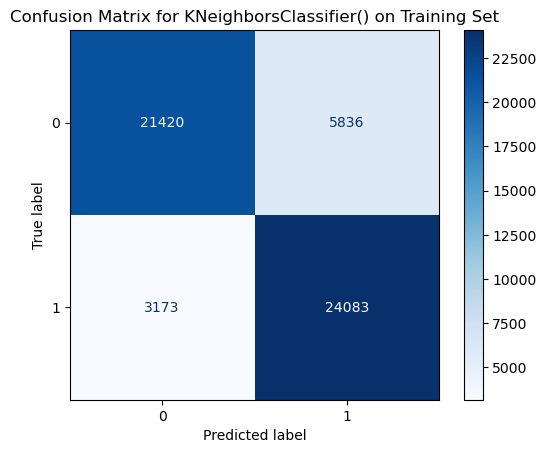

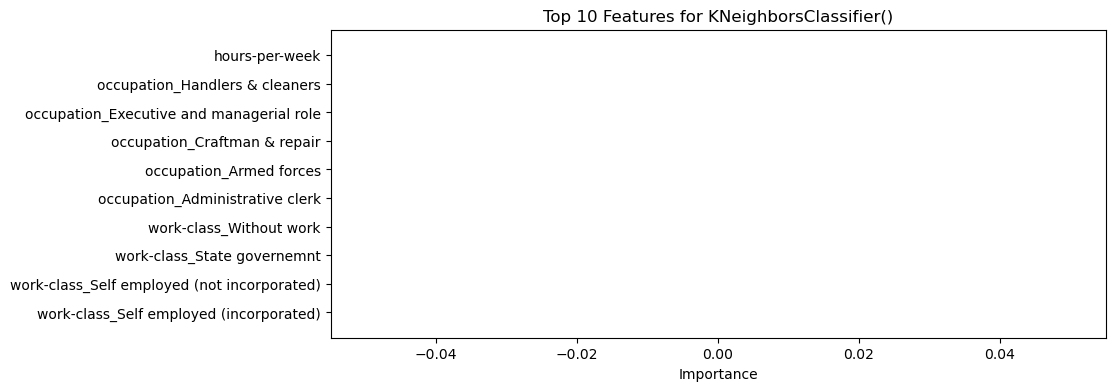

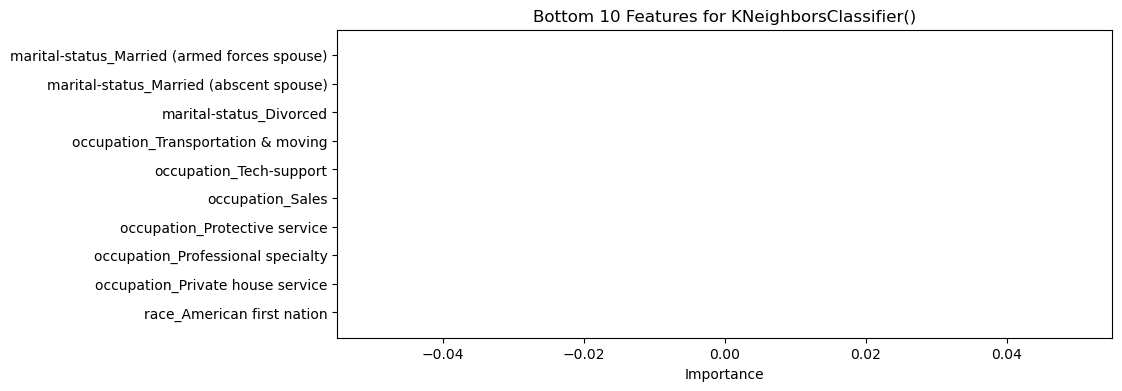

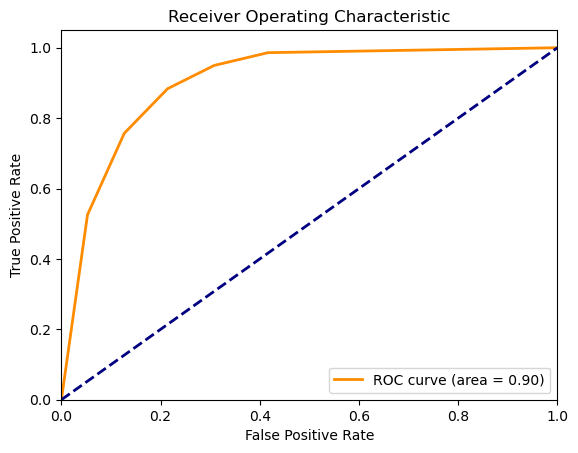



GradientBoostingClassifier(random_state=42)
Precision scores: [0.80864198 0.82101025 0.81425486 0.83333333 0.82887347 0.83704918
 0.83537595 0.84207056 0.83076923 0.83366206]
Mean Precision: 0.8285040874

Recall scores: [0.81694791 0.82281731 0.83009174 0.90091743 0.92073394 0.93688073
 0.92516508 0.93690389 0.93103448 0.93030081]
Mean Recall: 0.8951793332

F1 scores: [0.81277372 0.82191279 0.82209704 0.8658085  0.87239221 0.88415584
 0.87798085 0.88695954 0.87804878 0.87933426]
Mean F1: 0.8601463537

Accuracy scores: [0.81181218 0.8217168  0.82039993 0.86039259 0.86534581 0.87727023
 0.87139974 0.88057237 0.87066593 0.87231701]
Mean Accuracy: 0.8551892583

Roc_auc scores: [0.90620652 0.90900833 0.91051741 0.94259317 0.94819798 0.95232791
 0.94944806 0.95461186 0.95025524 0.95031373]
Mean Roc_auc: 0.9373480211

Classification Report for GradientBoostingClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.88      0.8

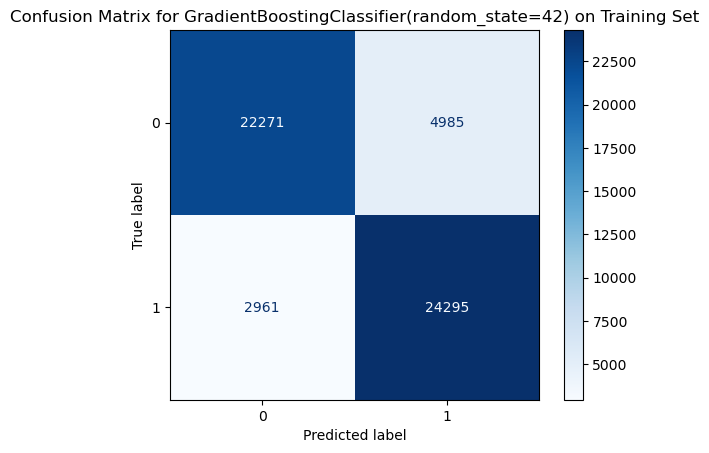

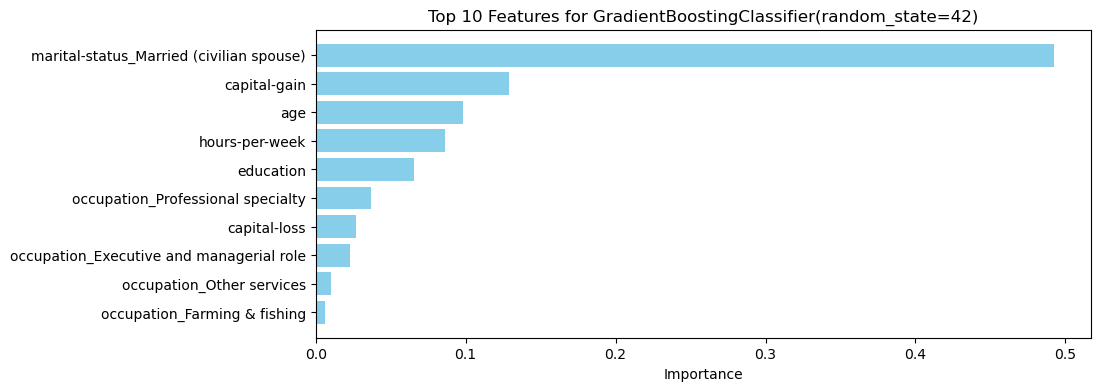

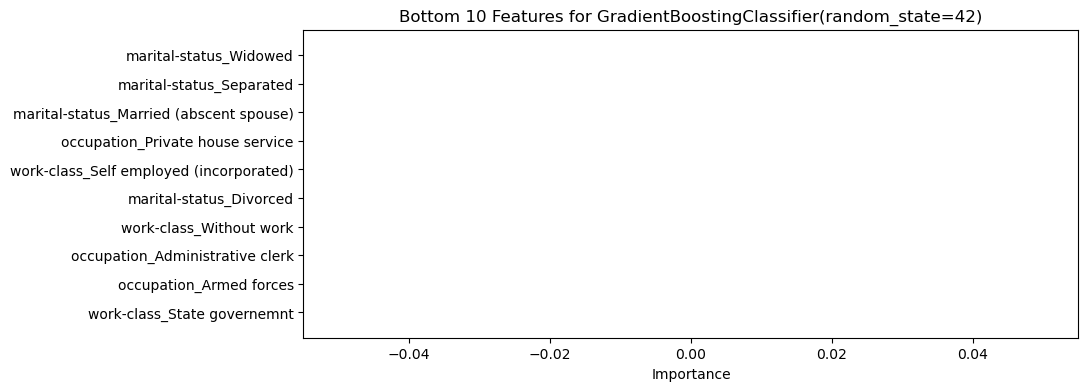

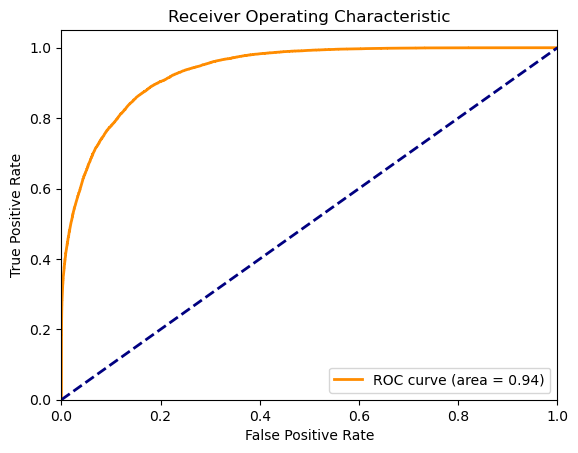



BaggingClassifier(random_state=42)
Precision scores: [0.85496183 0.85740741 0.85720803 0.88270011 0.88235294 0.875
 0.88630849 0.88873435 0.87980769 0.88321678]
Mean Precision: 0.8747697641

Recall scores: [0.69845928 0.67938371 0.68954128 0.87816514 0.93027523 0.94018349
 0.9380044  0.93763756 0.93983859 0.92663243]
Mean Recall: 0.8558121117

F1 scores: [0.76882697 0.75808432 0.76428717 0.88042678 0.9056806  0.90642137
 0.91142399 0.91253124 0.90883292 0.90440387]
Mean F1: 0.8620919231

Accuracy scores: [0.78998533 0.78319883 0.78737846 0.88075582 0.90313704 0.90295359
 0.90882407 0.91010824 0.90570538 0.90203632]
Mean Accuracy: 0.867408307

Roc_auc scores: [0.88376925 0.88036013 0.88732908 0.94611414 0.96271473 0.96409384
 0.96361648 0.96424448 0.96330713 0.96043031]
Mean Roc_auc: 0.9375979589

Classification Report for BaggingClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.85      0.88      0.86     27256
  

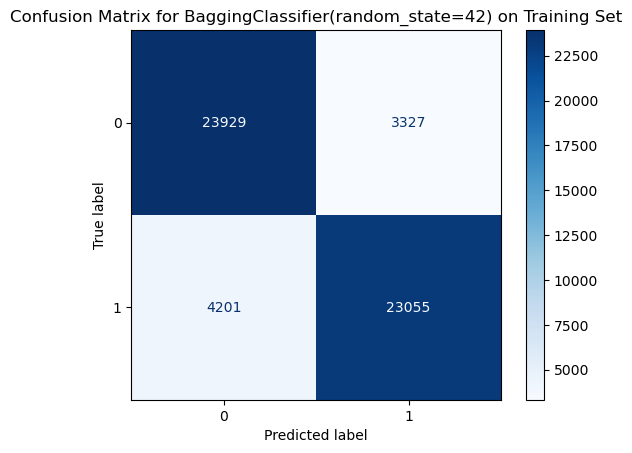

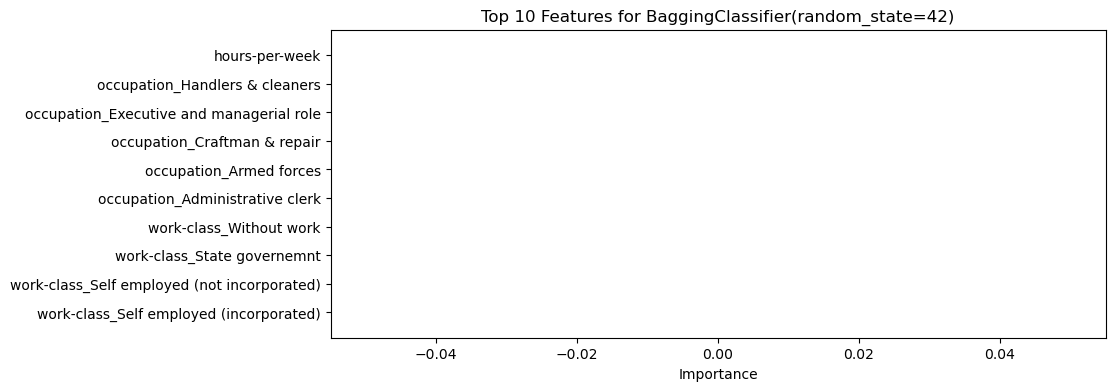

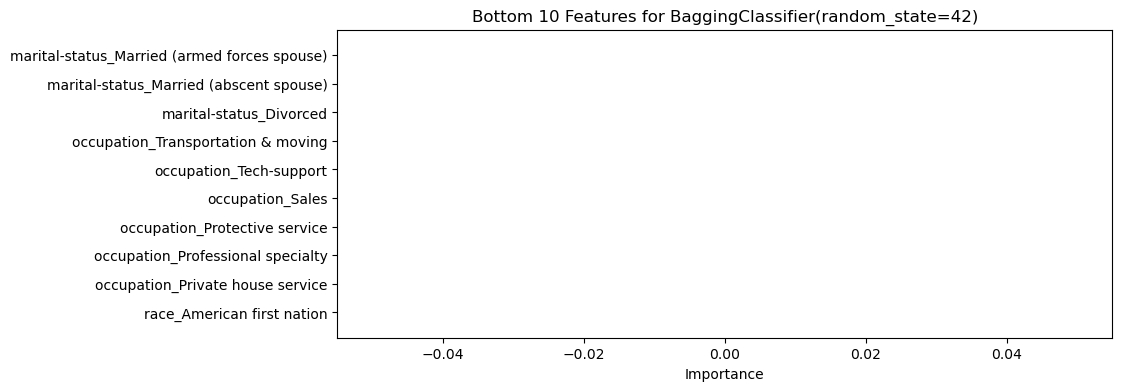

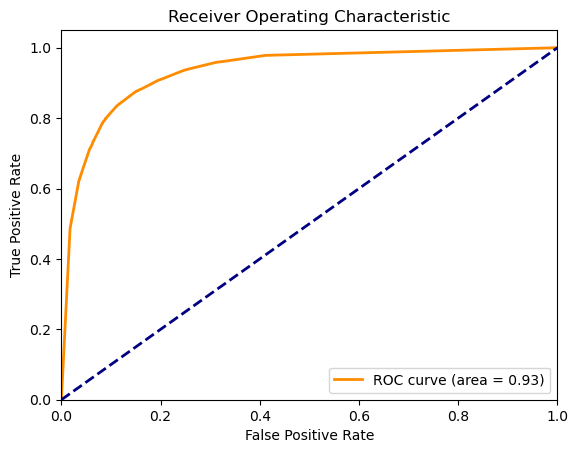



AdaBoostClassifier(random_state=42)
Precision scores: [0.8125937  0.82370706 0.82341938 0.83903134 0.83657858 0.83567753
 0.84035936 0.84110535 0.83768016 0.83541234]
Mean Precision: 0.832556481

Recall scores: [0.79530448 0.80044021 0.80770642 0.86458716 0.88293578 0.89394495
 0.89214967 0.89325018 0.89545121 0.88444607]
Mean Recall: 0.8610216131

F1 scores: [0.80385614 0.81190698 0.81548722 0.85161757 0.8591323  0.86382979
 0.86548043 0.86639388 0.86560284 0.85923022]
Mean F1: 0.8462537348

Accuracy scores: [0.80594277 0.81456346 0.81728123 0.84938543 0.85525592 0.85910842
 0.86130985 0.86222711 0.86094295 0.85507246]
Mean Accuracy: 0.8441089615

Roc_auc scores: [0.8976048  0.90349184 0.90740312 0.92944786 0.93383093 0.93592776
 0.93482409 0.94066657 0.93846258 0.93481177]
Mean Roc_auc: 0.9256471317

Classification Report for AdaBoostClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     2

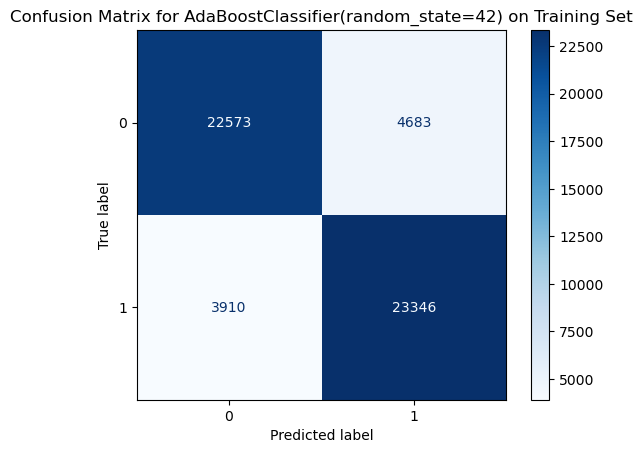

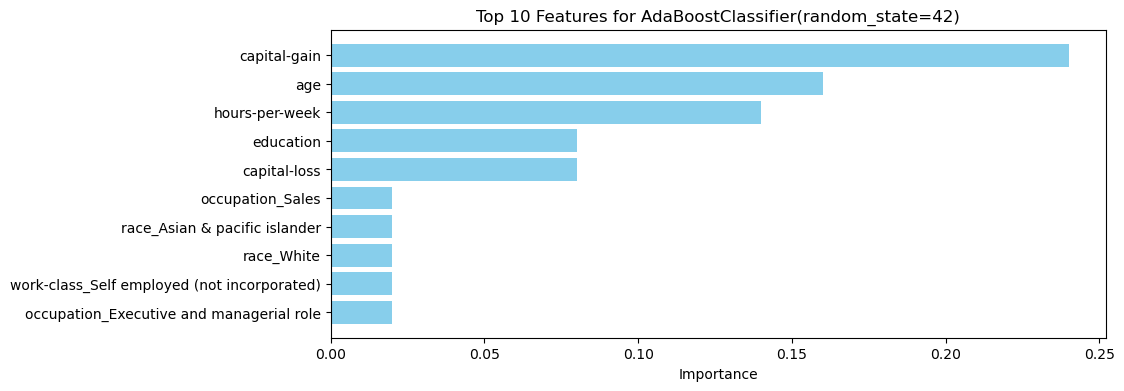

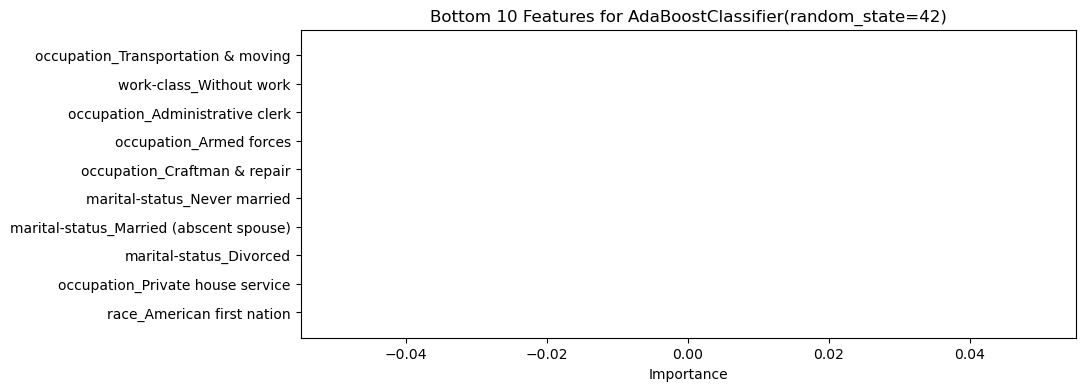

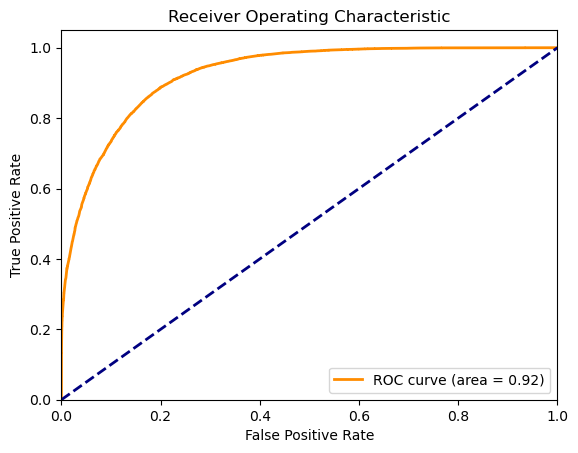



ExtraTreesClassifier(random_state=42)
Precision scores: [0.85364859 0.86471068 0.85957102 0.87446505 0.87721088 0.87538097
 0.87665647 0.88017802 0.88092801 0.87703804]
Mean Precision: 0.8719787745

Recall scores: [0.76815847 0.77842993 0.77944954 0.89981651 0.94642202 0.94862385
 0.94644167 0.94314013 0.94717535 0.94717535]
Mean Recall: 0.8904832836

F1 scores: [0.80865032 0.81930502 0.81755196 0.88695967 0.91050309 0.91053188
 0.91021344 0.91057199 0.91285133 0.91075838]
Mean F1: 0.8797897073

Accuracy scores: [0.81823184 0.82831988 0.82608696 0.88534214 0.90698954 0.90680609
 0.90662264 0.90735645 0.90955788 0.907173  ]
Mean Accuracy: 0.8802486415

Roc_auc scores: [0.88024117 0.88603144 0.88732242 0.93864977 0.95618435 0.95780577
 0.95530878 0.95606979 0.95657474 0.95350596]
Mean Roc_auc: 0.9327694191

Classification Report for ExtraTreesClassifier(random_state=42) on Training Set:

              precision    recall  f1-score   support

           0       0.89      0.86      0.88 

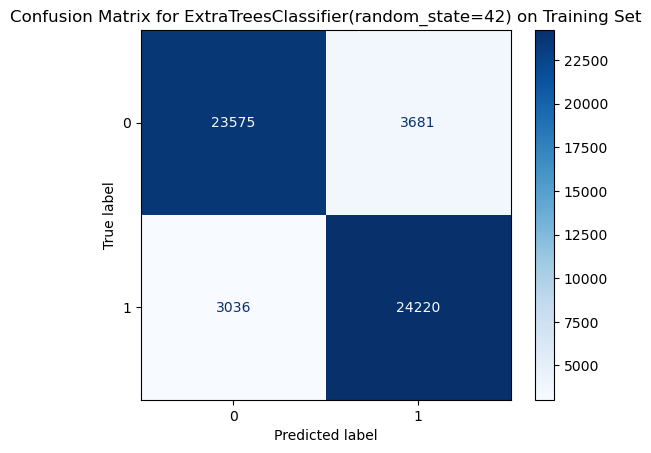

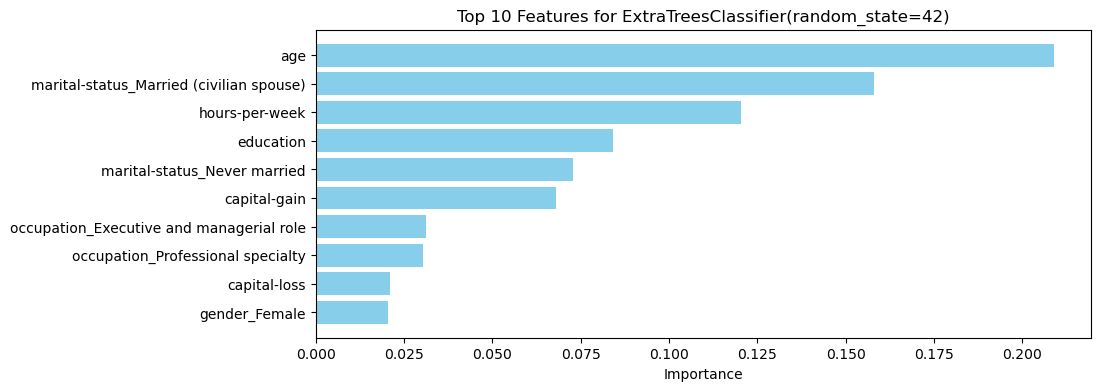

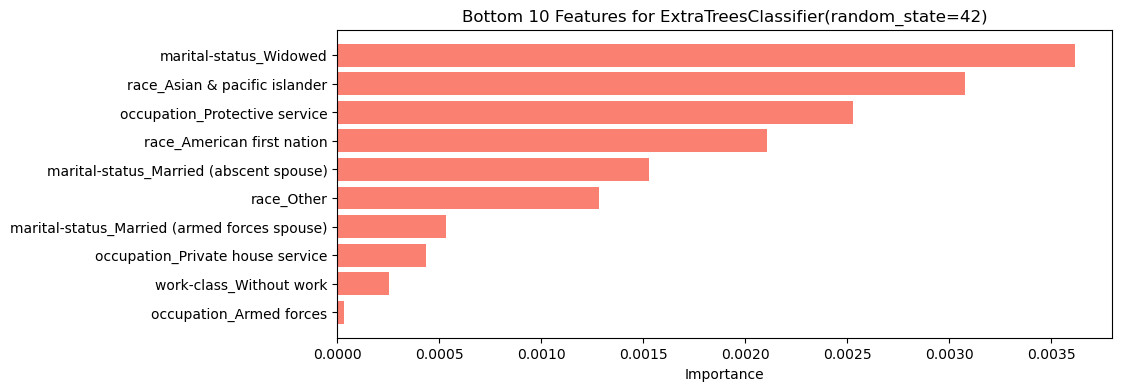

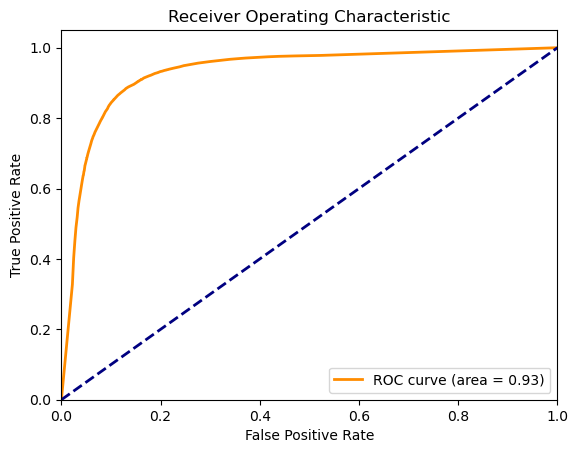

In [31]:
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
}

trained_models = evaluate_models(model_list, X_train, y_train, scoring)

## Top 3 models

- Extra Trees
- Random Forest
- Bagging

We will use precision as the metric

# Fine-Tune the top three models

## Extra Trees

In [47]:
def find_best_model(X_train, y_train):
    parameters = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

    ext_clf = ExtraTreesClassifier(random_state=42)
    grid_search = RandomizedSearchCV(ext_clf, parameters, scoring='precision', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)
    
    rand_res = grid_search.cv_results_
    print('*' * 50)
    for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
        print(mean_score, params)
    
    return best_model

In [48]:
best_model_extra_trees = find_best_model(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
**************************************************
0.8015894797089227 {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': None}
0.7591609756151213 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10}
0.7343857733911934 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
0.7936483141498011 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': None}
0.8483536677259491 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
0.7341618627070811 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 5}
0.7996512186901952 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': None}
0.7986824584968583 {'n_estimato

In [49]:
precision_score_extra_trees = np.mean(cross_val_score(best_model_extra_trees,X_train,y_train, scoring='precision',cv=10,n_jobs=-1,verbose=3))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 62.9min finished


In [50]:
precision_score_extra_trees

0.858054641357098

## Random Forest

In [32]:
def find_best_model(X_train, y_train):
    parameters = {
    'n_estimators' : [100, 200, 300, 500, 800, 1200],
    'max_features' : ['log2', 'sqrt'],
    'max_depth' : [10, 20, 30, 40, 50, 60, None],
    'min_samples_split' : [2, 5, 10, 15, 100],
    'min_samples_leaf' : [1, 2, 5, 10],
}

    rf = RandomForestClassifier(random_state=42)
    grid_search = RandomizedSearchCV(rf, parameters, scoring='precision', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)
    
    rand_res = grid_search.cv_results_
    print('*' * 50)
    for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
        print(mean_score, params)
    
    return best_model

In [33]:
best_model_rand_forest = find_best_model(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}
**************************************************
0.8211399901624193 {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 50}
0.8466164880640038 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}
0.8428664714242187 {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
0.8412180079455543 {'n_estimators': 1200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
0.8321096482756598 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 30}
0.8195547754869104 {'n_estimators': 300, 'min_samples_split': 100, 'min_samples_leaf': 10, 'max_fea

In [35]:
precision_score_rand_for = np.mean(cross_val_score(best_model_rand_forest,X_train,y_train, scoring='precision',cv=10,n_jobs=-1,verbose=3))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.1min finished


In [36]:
precision_score_rand_for

0.8520386143089876

## Bagging

In [39]:
def find_best_model(X_train, y_train):
    parameters = {
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'max_features' : [0.6, 0.8, 1.0]
}

    bag_clf = BaggingClassifier(random_state=42)
    grid_search = RandomizedSearchCV(bag_clf, parameters, scoring='precision', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print("Best parameters found: ", grid_search.best_params_)
    
    rand_res = grid_search.cv_results_
    print('*' * 50)
    for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
        print(mean_score, params)
    
    return best_model

In [40]:
best_model_bag_clf = find_best_model(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 15, 'max_samples': 0.6, 'max_features': 0.6, 'bootstrap_features': True, 'bootstrap': False}
**************************************************
0.8898045873458247 {'n_estimators': 15, 'max_samples': 0.6, 'max_features': 0.6, 'bootstrap_features': False, 'bootstrap': False}
0.8930160103038892 {'n_estimators': 15, 'max_samples': 1.0, 'max_features': 0.8, 'bootstrap_features': True, 'bootstrap': False}
0.8693772602538784 {'n_estimators': 5, 'max_samples': 0.6, 'max_features': 0.6, 'bootstrap_features': True, 'bootstrap': False}
0.8760936538641704 {'n_estimators': 10, 'max_samples': 1.0, 'max_features': 0.8, 'bootstrap_features': True, 'bootstrap': True}
0.8939510822488655 {'n_estimators': 15, 'max_samples': 1.0, 'max_features': 0.6, 'bootstrap_features': True, 'bootstrap': True}
0.8701872080037907 {'n_estimators': 5, 'max_samples': 1.0, 'max_features': 0.8, 'bootstrap_features': False, 'b

In [43]:
precision_score_bag_clf = np.mean(cross_val_score(best_model_bag_clf,X_train,y_train, scoring='precision',cv=10,n_jobs=-1,verbose=3))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.3min finished


In [44]:
precision_score_bag_clf

0.8934238606543057

# Test the performance of the model on the test set

In [51]:
test_copy.head()

,age,work-class,final-weight,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,33,Self employed (incorporated),128016,High school graduate,9,Widowed,Sales,Not married,White,Female,0,0,40,United-States,<=50K
1,60,Private sector,120067,9th grade,5,Married (civilian spouse),Farming & fishing,Husband,White,Male,0,0,45,United-States,<=50K
2,46,Private sector,411037,10th grade,6,Divorced,Sales,Not married,White,Female,0,0,35,United-States,<=50K
3,35,State governemnt,210866,High school graduate,9,Married (civilian spouse),Other services,Husband,White,Male,0,0,40,United-States,<=50K
4,34,Private sector,197886,Bachelor's degree,13,Married (civilian spouse),Sales,Husband,White,Male,0,0,60,United-States,>50K


In [52]:
# Apply the pipeline to the test DataFrame
test_pipe_prep = pipeline.fit_transform(test_copy)

In [53]:
# split the test data into X and y (target)
X_test, y_test = test_pipe_prep.loc[:, test_pipe_prep.columns != 'income_>50K'], test_pipe_prep['income_>50K']

In [58]:
best_model_extra_trees

ExtraTreesClassifier(min_samples_split=10, n_estimators=500, random_state=42)

In [55]:
# Extra trees
extra_trees_predictions = best_model_extra_trees.predict(X_test)
n_correct = sum(extra_trees_predictions == y_test)
print(n_correct/len(extra_trees_predictions))

0.8505253810862808


In [59]:
best_model_rand_forest

RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500, random_state=42)

In [56]:
# Random Forest
rand_for_predictions = best_model_rand_forest.predict(X_test)
n_correct = sum(rand_for_predictions == y_test)
print(n_correct/len(rand_for_predictions))

0.8598490454343644


In [60]:
best_model_bag_clf

BaggingClassifier(bootstrap=False, bootstrap_features=True, max_features=0.6,
                  max_samples=0.6, n_estimators=15, random_state=42)

In [57]:
# Bagging
bag_clf_predictions = best_model_bag_clf.predict(X_test)
n_correct = sum(bag_clf_predictions == y_test)
print(n_correct/len(bag_clf_predictions))

0.8753144886784076


# Best Model

- Bagging

In [61]:
joblib.dump(best_model_bag_clf, "bagging_model.sav")

['bagging_model.sav']